In [1]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import re
import datetime

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
sns.set(palette="bright")
sns.set_style("whitegrid")

from sklearn import linear_model
from cycler import cycler
from celluloid import Camera

from IPython.display import HTML

import importlib

#importlib.reload(some_module)


import warnings

import numpy as np
import pandas as pd
import copy
import random


from tslib.src import tsUtils
from tslib.src.synthcontrol.syntheticControl import RobustSyntheticControl
from tslib.tests import testdata

#warnings.filterwarnings(action='once')

from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

import hdbscan


In [22]:
# function to create filtered dataframe based on thressholds and align timeseries to that start of the spread

def create_filtered_data(df, threshold):
    pattern = re.compile('(Unknown|Unassigned)')
    newdf = pd.DataFrame()
    for location in df.columns:
        if(pattern.search(location)):
            continue
        highnumber = df[df[location].gt(threshold)]
        if(len(highnumber)>0):
            newdf = pd.concat([newdf, pd.DataFrame(columns=[location], data=df.loc[highnumber.index[0]:,location].values)], axis=1)
    return newdf

# function to create filtered dataframe based on intervention dates and align timeseries

def filter_data_by_intervention(df, intervention, lag=0):
    newdf = pd.DataFrame()
    if (lag > 0):
        subscript=" -"+str(lag)
    elif (lag < 0):
        subscript=" +"+str(np.abs(lag))
    else:
        subscript=""
    for state in df.columns:
        intervention_date = intervention[intervention.name == state].date.values
        if(intervention_date.size>0):
            newdata = df.loc[pd.to_datetime(df.index)>=pd.to_datetime(intervention_date[0])][state].values
            if(np.isnan(newdata[:5]).any()):
                print(state)
                continue
            newdf = pd.concat([newdf, pd.DataFrame(columns=[state+subscript],
                                                       data=df.loc[pd.to_datetime(df.index) >= pd.to_datetime(intervention_date[0]) - 
                                                                         datetime.timedelta(days=lag)][state].values)], axis=1)
    return newdf

def get_social_distancing(df, intervention_tried):
    social_distancing = df[['country','name',intervention_tried]].copy(deep=True)
    print(intervention_tried)
    exception_list = []
    for place in social_distancing.name:
    
        try:
            new_value = pd.to_datetime(social_distancing[social_distancing.name == place][intervention_tried],format = '%d.%m.%Y')
            social_distancing.loc[social_distancing.name == place, "date"] = new_value
        except ValueError:
            exception_list.append(place)
    print("Exceptions are", exception_list)
    return social_distancing

def mse(y1, y2):
    return np.sum((y1 - y2) ** 2) / len(y1)/np.sqrt(np.square(y1).sum())


# function to build and plot synthetic control baswed projections. The first threshold is which regions to use in the donor pool 
# - the ones that have had the timeseries for threshold days and above. The low_thresh is to do predictions for regions that
# have had the spread for at least low_thresh days but below threshold days

# for i in range(20):
#    synth_control_predictions(trial,35,5+i, "Rolling 5-day average deaths data", 2, ylimit=[], savePlots=False, do_only=target, showstates=12,
#                               exclude=exclude1, animation=camera)
 
def synth_control_predictions(list_of_dfs, threshold, low_thresh,  title_text, singVals=2, 
                               savePlots=False, ylimit=[], logy=False, exclude=[], 
                               svdSpectrum=False, showDonors=True, do_only=[], showstates=4, animation=[], 
                              donorPool=[], silent=True, showPlots=True, mRSC=False, lambdas=[1], error_thresh=1):
    #print('yo', list_of_dfs,'bo')
    #print(len(list_of_dfs))
    df = list_of_dfs[0]
    sizes = df.apply(pd.Series.last_valid_index)
    sizes = sizes.fillna(0).astype(int)
    
    if (donorPool):
        otherStates=donorPool.copy()
    else:
        otherStates = list(sizes[sizes>threshold].index)
    if(exclude):
        for member in exclude:
            if(member in otherStates):
                otherStates.remove(member)
    if(do_only):
        for member in exclude:
            if(member in otherStates):
                otherStates.remove(member)
        for member in do_only:
            if(member in otherStates):
                otherStates.remove(member)
            
    
    showstates = np.minimum(showstates,len(otherStates))
    otherStatesNames = otherStates
    otherStatesNames = [w.replace('-None', '') for w in otherStates]
    
    for state in otherStatesNames:
        state.replace("-None","")
    if not silent:
        print(otherStates)
    if(do_only):
        prediction_states = list(sizes[sizes.index.isin(do_only)].index)
        if not silent:
            print(prediction_states)
    else:
        prediction_states = list(sizes[(sizes>low_thresh) & (sizes<=threshold)].index)
    
    
    for state in prediction_states:
        all_rows = list.copy(otherStates)
        all_rows.append(state)
        if not mRSC:
            trainDF=df.iloc[:low_thresh,:]
        else:
            num_dimensions = len(lambdas)
            trainDF=pd.DataFrame()
            length_one_dimension = list_of_dfs[0].shape[0]
            for i in range(num_dimensions):
                trainDF=pd.concat([trainDF,lambdas[i]*list_of_dfs[i].iloc[:low_thresh,:]], axis=0)
        if not silent:
            print(trainDF.shape)        
        testDF=df.iloc[low_thresh+1:threshold,:]
        rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
        rscModel.fit(trainDF)
        denoisedDF = rscModel.model.denoisedDF()
        predictions = []
    
        predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
        predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
        x_actual=range(sizes[state])
        actual = df.iloc[:sizes[state],:][state]
        
        if (svdSpectrum):
            (U, s, Vh) = np.linalg.svd((trainDF[all_rows]) - np.mean(trainDF[all_rows]))
            s2 = np.power(s, 2)
            plt.figure(figsize=(8,6))
            plt.plot(s2)
            plt.grid()
            plt.xlabel("Ordered Singular Values") 
            plt.ylabel("Energy")
            plt.title("Singular Value Spectrum")
            plt.show()
        x_predictions=range(low_thresh,low_thresh+len(predictions))
        model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
        error = mse(actual[:low_thresh], model_fit)
        if not silent:
            print(state, error)
        if showPlots:
            plt.figure(figsize=(16,6))
        ind = np.argpartition(rscModel.model.weights, -showstates)[-showstates:]
        topstates = [otherStates[i] for i in ind]
        if(showDonors):
            plt.subplot(121)        
            plt.barh(otherStates, rscModel.model.weights/np.max(rscModel.model.weights), color=list('rgbkymc'))
            plt.title("Normalized weights for "+str(state).replace("-None",""))
            plt.subplot(122)
        
        if(ylimit):
            plt.ylim(ylimit)
        if(logy):
            plt.yscale('log')
        if(showPlots):
            plt.plot(x_actual,actual,label='Actuals', color='k', linestyle='-')
            plt.plot(x_predictions,predictions,label='Predictions', color='r', linestyle='--')
            plt.plot(range(len(model_fit)), model_fit, label = 'Fitted model', color='g', linestyle=':')
            plt.axvline(x=low_thresh-1, color='k', linestyle='--', linewidth=4)
            plt.title(title_text+" for "+str(state).replace("-None",""))
            plt.xlabel("Days since Intervention")
            plt.ylabel("Deaths")
            plt.legend(['Actuals', 'Predictions', 'Fitted Model'])
            plt.grid()
            if (savePlots):
                plt.savefig("../Figures/COVID/"+state+".png")        
            if(animation):
                animation.snap()           
            else:
                plt.show()    
    if(error<error_thresh):
        return(dict(zip(otherStates, rscModel.model.weights)))
    else:
        print(state, error)
        return(dict(zip(otherStates, -50*np.ones(len(rscModel.model.weights)))))
# function to track peaks in cases or death rates
def create_peak_clusters(df, threshold=5):
    df_temp = df
    df_cluster = pd.DataFrame(data=df_temp.idxmax(), columns=["days to peak"])
    df_cluster['sizes']=df_temp.apply(pd.Series.last_valid_index)
    df_cluster['peak value'] = df_temp.max()
    df_cluster['initial value'] = df_temp.iloc[0,:]
    df_cluster['sizes'] = df_cluster['sizes'].fillna(0)
    global_peak_size = df_cluster.loc[df_cluster['sizes'] - df_cluster['days to peak'] > threshold]
    #plt.scatter(global_peak_size['days to peak'], (global_peak_size['peak value']), s=2*global_peak_size['initial value']), 
    return global_peak_size
        
#global settings for graphs        
cc = (cycler(linestyle=['-', '--', '-.',':']) * cycler(color=list('brgcmyk')))
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=cc)
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (8.0, 6.0)

plt.rcParams["animation.html"] = "html5"

In [14]:
# load and clean NYTimes data
us = pd.read_csv("../COVID/covid-19-data/us.csv")
usstates = pd.read_csv("../COVID/covid-19-data/us-states.csv")
uscounties = pd.read_csv("../COVID/covid-19-data/us-counties.csv")
uscounties['county_state']=uscounties['county']+'-'+uscounties['state']
uscases = usstates.pivot(index='date', columns='state', values='cases')
usdeaths= usstates.pivot(index='date', columns='state', values='deaths')
uscounties_deaths = uscounties.pivot_table(index='date', columns='county_state', values='deaths')
uscounties_cases = uscounties.pivot_table(index='date', columns='county_state', values='cases')



# load and clean JHU data
global_covid = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
us_covid_jhu = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")
global_covid_cases = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

global_covid['Province-Country']=global_covid['Country/Region']+'-'+global_covid['Province/State'].fillna("None")
global_covid['Province-Country'] = global_covid['Province-Country'].str.replace("-None","")
global_covid=global_covid.set_index('Province-Country')
global_covid.rename(index={'Georgia':'Georgian Republic'},inplace=True)
global_deaths = global_covid.loc[:,'1/22/20':].T

global_covid_cases['Province-Country']=global_covid_cases['Country/Region']+'-'+global_covid_cases['Province/State'].fillna("None")
global_covid_cases['Province-Country'] = global_covid_cases['Province-Country'].str.replace("-None","")
global_covid_cases=global_covid_cases.set_index('Province-Country')
global_covid_cases.rename(index={'Georgia':'Georgian Republic'},inplace=True)
global_cases = global_covid_cases.loc[:,'1/22/20':].T

us_covid_jhu=us_covid_jhu.set_index('Combined_Key')
us_covid_jhu_deaths = us_covid_jhu.loc[:,'1/22/20':].T

global_country_aggr = global_covid.groupby('Country/Region').sum()

global_cases.index = pd.to_datetime(global_cases.index, format = '%m/%d/%y').strftime('%Y-%m-%d')
global_deaths.index = pd.to_datetime(global_deaths.index, format = '%m/%d/%y').strftime('%Y-%m-%d')


# load and clean mobility data

mobility_data_apple = pd.read_csv("../data/applemobilitytrends-2020-05-30.csv")
mobility_data_google = pd.read_csv("../data/Global_Mobility_Report.csv", low_memory=False)

# load and clean IHME intervention data

sd_data = pd.read_csv("../data/sdc_sources.csv")
sd_data['last date'] = 'none'
for index, row in sd_data.iterrows():
    if row['Mass gathering restrictions']=="full implementation":
        #print(row['name'])
        row['Mass gathering restrictions']=row['Stay at Home Order']
    if row['Initial business closures']=="full implementation":
        #print(row['name'])
        row['Initial business closures']=row['Non-essential services closed']
    dates_of_intervention=[]
    for i in range(3,7):
        try:
            new_value = pd.to_datetime(row[sd_data.columns[i]],format = '%d.%m.%Y')
            dates_of_intervention.append(new_value)                             
        except ValueError:
            pass
    
    row['last date'] = np.max(dates_of_intervention)
    
fips_df = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

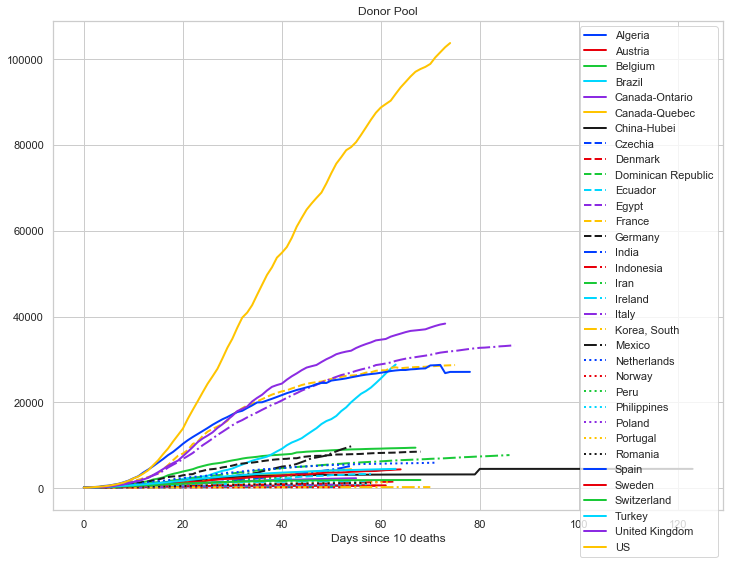

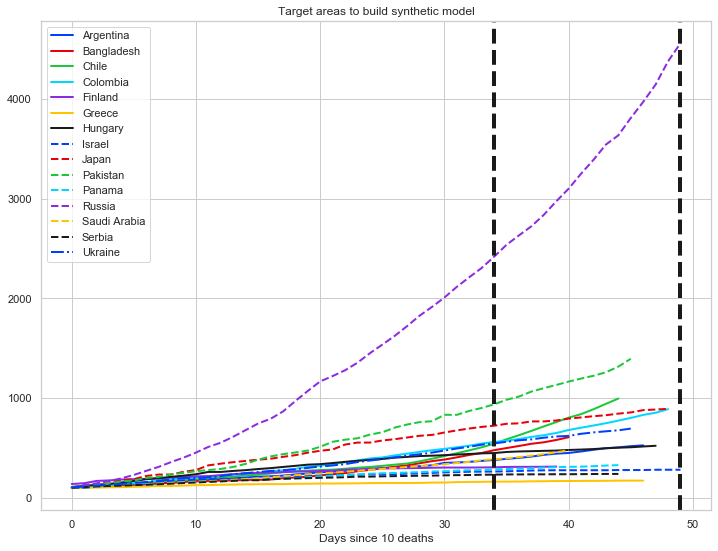

In [15]:
plt.rcParams['figure.figsize'] = (12.0, 9.0)
plt.rcParams.update({'font.size': 8})

global_deaths_filtered = create_filtered_data(global_deaths, 100 )

sizes = global_deaths_filtered.apply(pd.Series.last_valid_index)
  
low_thresh=35
threshold=50
donorlpool = list(sizes[sizes>threshold].index)

global_deaths_filtered[donorlpool].plot( grid=True, title='Donor Pool', linewidth=2)
plt.xlabel('Days since 10 deaths')
plt.show()

prediction_states = list(sizes[(sizes>low_thresh) & (sizes<threshold)].index)
global_deaths_filtered[prediction_states].plot(grid=True, title='Target areas to build synthetic model', linewidth=2)
plt.xlabel('Days since 10 deaths')
plt.axvline(x=low_thresh-1, color='k', linestyle='--', linewidth=4)
plt.axvline(x=threshold-1, color='k', linestyle='--', linewidth=4)


plt.show()


In [16]:
mobility_global = mobility_data_google.pivot_table(index='date', values='retail_and_recreation_percent_change_from_baseline', columns='country_region')

google_work_country = mobility_data_google.pivot_table(index='date', columns='country_region', values='workplaces_percent_change_from_baseline')
global_google = google_work_country[google_work_country.lt(-30)].apply(pd.Series.first_valid_index)
google_work_us = mobility_data_google[mobility_data_google.country_region ==  "United States"].pivot_table(index='date', values=mobility_data_google.columns[9], columns='sub_region_1')
us_google = google_work_us[google_work_us.lt(-30)].apply(pd.Series.first_valid_index)
google_social = pd.DataFrame(data=pd.concat([global_google, us_google]), columns=['date'])
google_social['date'] = pd.to_datetime(google_social['date'])
google_social['name'] = google_social.index

In [17]:
rolling_average_duration = 5

daily_global_raw = create_filtered_data(global_deaths,5).diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
daily_us_raw = create_filtered_data(usdeaths,5).diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
daily_uscounties_raw = create_filtered_data(uscounties_deaths,5).diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]


In [18]:
print(sd_data.columns)
intervention_tried = sd_data.columns[7]
def get_social_distancing(df, intervention_tried):
    social_distancing = df[['country','name',intervention_tried]].copy(deep=True)
    print(intervention_tried)
    exception_list = []
    for place in social_distancing.name:
    
        try:
            new_value = pd.to_datetime(social_distancing[social_distancing.name == place][intervention_tried],format = '%d.%m.%Y')
            social_distancing.loc[social_distancing.name == place, "date"] = new_value
        except ValueError:
            exception_list.append(place)
    print("Exceptions are", exception_list)
    return social_distancing


Index(['name', 'country', 'admin1', 'Mass gathering restrictions',
       'Stay at Home Order', 'Educational facilities closed',
       'Initial business closures', 'Non-essential services closed',
       'Travel severely limited', 'Source Mass gathering restrictions',
       'Source Stay at Home Order', 'Source Educational facilities closed',
       'Source Initial business closure',
       'Source Non-essential services closed',
       'Source Travel severely limited', 'last date'],
      dtype='object')


In [8]:
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

last date
Exceptions are []


In [9]:
print(educational_distancing)

     country               name            last date       date
0    Germany  Baden-Wurttemberg  2020-03-21 00:00:00 2020-03-21
1    Germany            Bavaria  2020-03-21 00:00:00 2020-03-21
2    Germany             Berlin  2020-03-23 00:00:00 2020-03-23
3    Germany        Brandenburg  2020-03-18 00:00:00 2020-03-18
4    Germany             Bremen  2020-03-22 00:00:00 2020-03-22
..       ...                ...                  ...        ...
143    Malta              Malta  2020-03-17 00:00:00 2020-03-17
144   Cyprus             Cyprus  2020-03-24 00:00:00 2020-03-24
145  Iceland            Iceland  2020-03-24 00:00:00 2020-03-24
146    China        China-Hubei  2020-01-23 00:00:00 2020-01-23
147    India              India  2020-03-24 00:00:00 2020-03-24

[148 rows x 4 columns]


In [10]:
rolling_average_duration = 7


all_data = pd.concat([global_deaths, usdeaths], axis=1)  
all_data = pd.concat([all_data, uscounties_deaths], axis=1)

all_data_daily = all_data.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]

all_data_cases = pd.concat([global_cases, uscases], axis=1) 

all_data_cases = pd.concat([all_data_cases, uscounties_cases], axis=1)


all_data_cases_daily = all_data_cases.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]


In [11]:
newdf=filter_data_by_intervention(usdeaths, educational_distancing)
newdf_global=filter_data_by_intervention(global_deaths, educational_distancing)
newdf_uscounties=filter_data_by_intervention(uscounties_deaths, educational_distancing)

cases_intervention_adjusted = filter_data_by_intervention(all_data_cases, educational_distancing)
deaths_intervention_adjusted = filter_data_by_intervention(all_data, educational_distancing)
deaths_intervention_adjusted_google =  filter_data_by_intervention(all_data, google_social)

rolling_average_duration = 7

daily_global = newdf_global.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
daily_us = newdf.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
daily_uscounties = newdf_uscounties.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]

cases_intervention_adjusted_daily = cases_intervention_adjusted.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
deaths_intervention_adjusted_daily = deaths_intervention_adjusted.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
deaths_intervention_adjusted_daily_google = deaths_intervention_adjusted_google.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]

cases_intervention_adjusted_daily.index = cases_intervention_adjusted_daily.index-rolling_average_duration
deaths_intervention_adjusted_daily.index = deaths_intervention_adjusted_daily.index-rolling_average_duration
deaths_intervention_adjusted_daily_google.index = deaths_intervention_adjusted_daily_google.index-rolling_average_duration

Alaska
District of Columbia
Hawaii
Maine
Maryland
Nevada
New Jersey
Rhode Island
Utah


['Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'India', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 

<Figure size 1152x432 with 0 Axes>

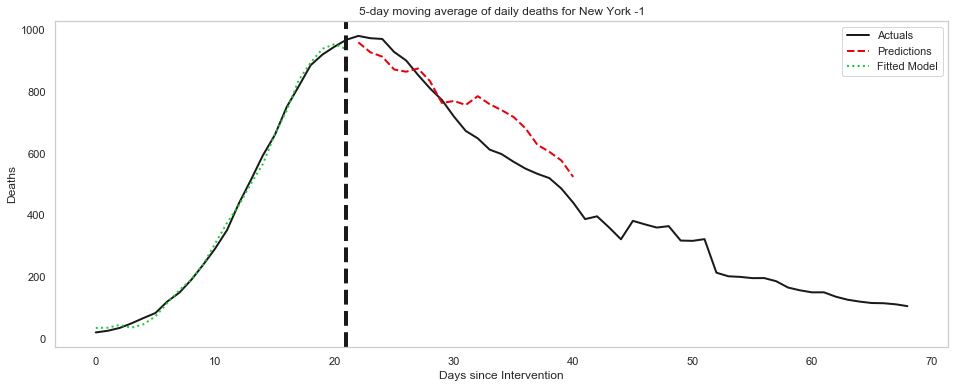

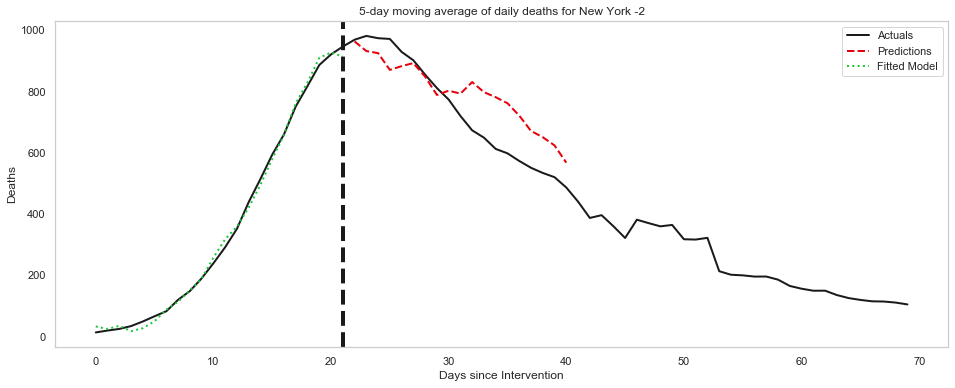

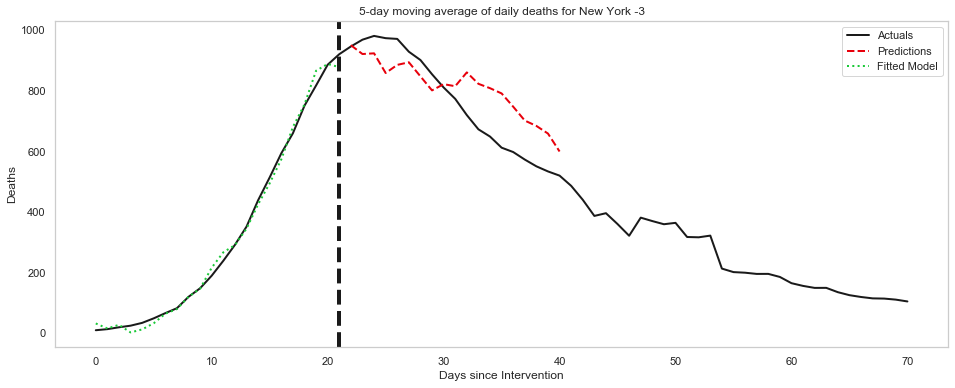

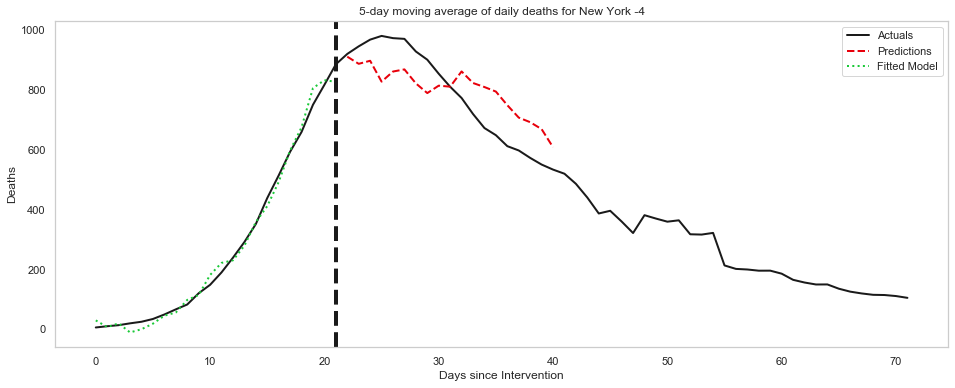

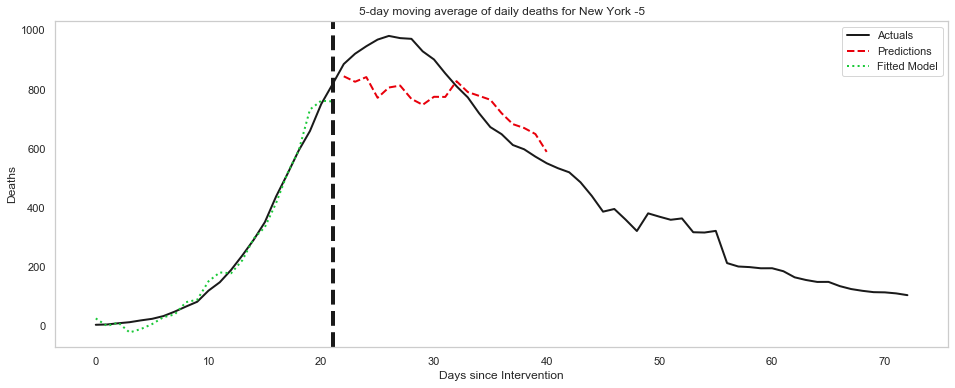

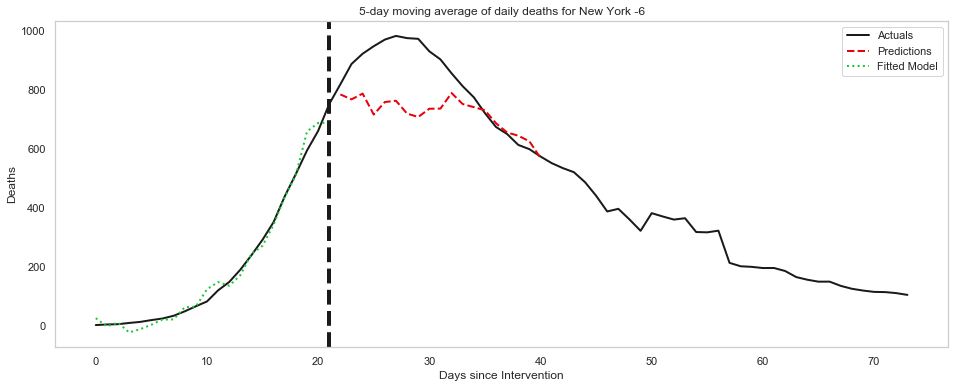

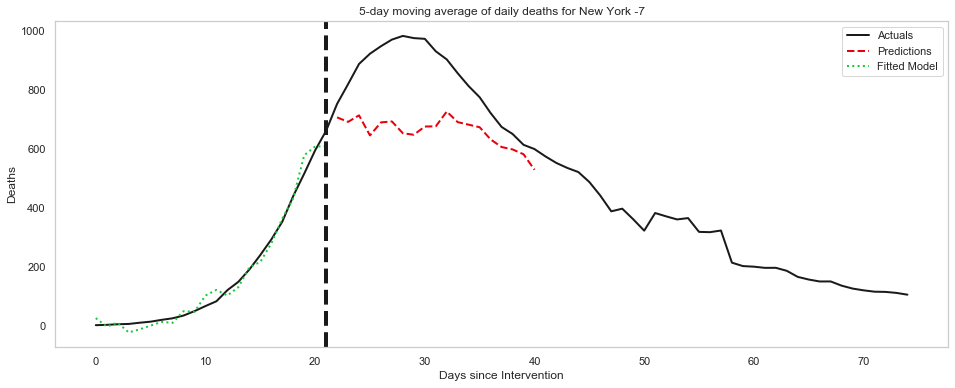

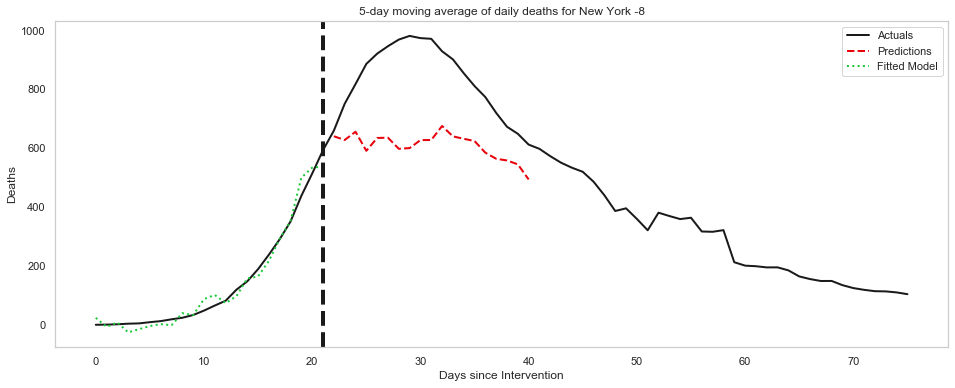

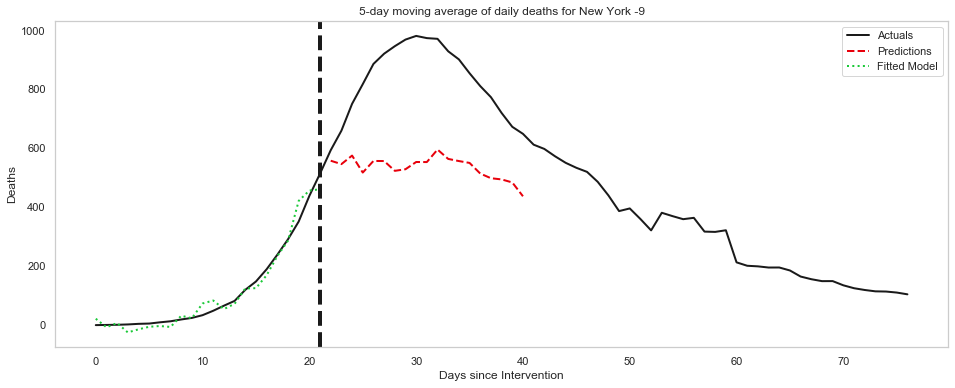

In [23]:

targets = ['New York']# 'Italy', 'Spain', 'United Kingdom', 'France']

singVals = 5

    


for target in targets:
    fig = plt.figure(figsize=(16,6))
    camera = Camera(fig)
    
    for i in range(1,10):
        temp_df = filter_data_by_intervention(all_data_daily[[target]], educational_distancing, i)

        return_value = synth_control_predictions([pd.concat([deaths_intervention_adjusted_daily,temp_df], axis=1)], 42,22, "5-day moving average of daily deaths", singVals, ylimit=[], 
                                   savePlots=False, do_only=[target+" -%s"%i], showstates=12,
                                   exclude=[target], animation=camera, showDonors=False, silent=False, showPlots=True)
    

#animation = camera.animate()
#HTML(animation.to_html5_video())

    
    #HTML(animation_final.to_jshtml())

    #animation_final.save('../animations/'+target+' no donors new.mp4')

['Italy', 'Spain', 'France', 'China-Hubei']
['New York']
(3, 88)
New York 0.05308835713274932
['Italy', 'Spain', 'France', 'China-Hubei']
['New York']
(4, 88)
New York 0.06618187715395342
['Italy', 'Spain', 'France', 'China-Hubei']
['New York']
(5, 88)
New York 0.17244010682985378
['Italy', 'Spain', 'France', 'China-Hubei']
['New York']
(6, 88)
New York 0.16272045869805873
['Italy', 'Spain', 'France', 'China-Hubei']
['New York']
(7, 88)
New York 0.19351704213282853
['Italy', 'Spain', 'France', 'China-Hubei']
['New York']
(8, 88)
New York 0.22463346201005838
['Italy', 'Spain', 'France', 'China-Hubei']
['New York']
(9, 88)
New York 0.5796193719400228
['Italy', 'Spain', 'France', 'China-Hubei']
['New York']
(10, 88)
New York 0.949069013459568
['Italy', 'Spain', 'France', 'China-Hubei']
['New York']
(11, 88)
New York 0.4402242148287691


<Figure size 1152x432 with 0 Axes>

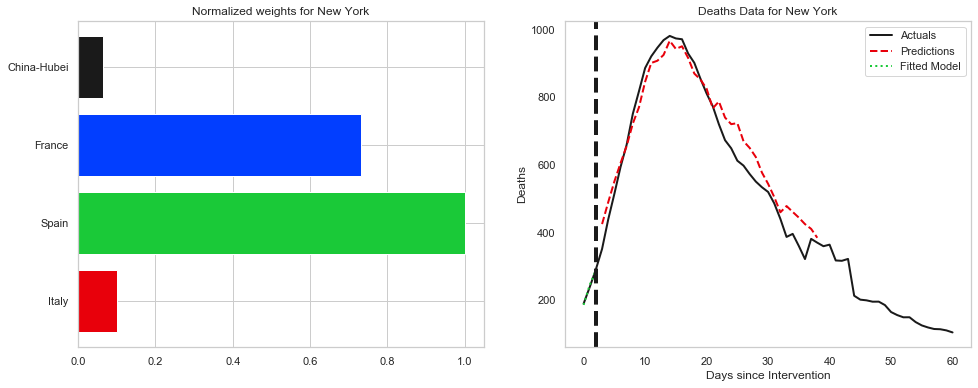

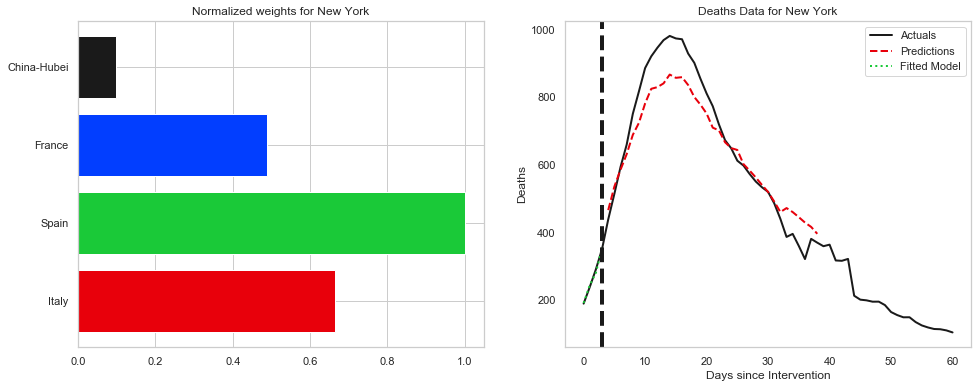

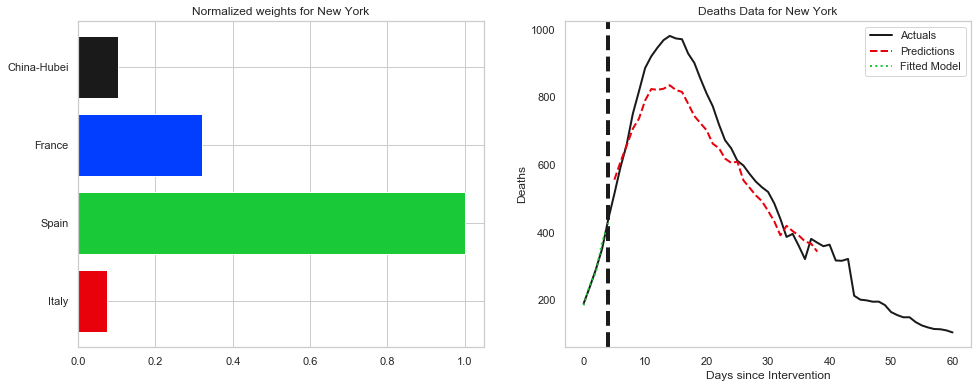

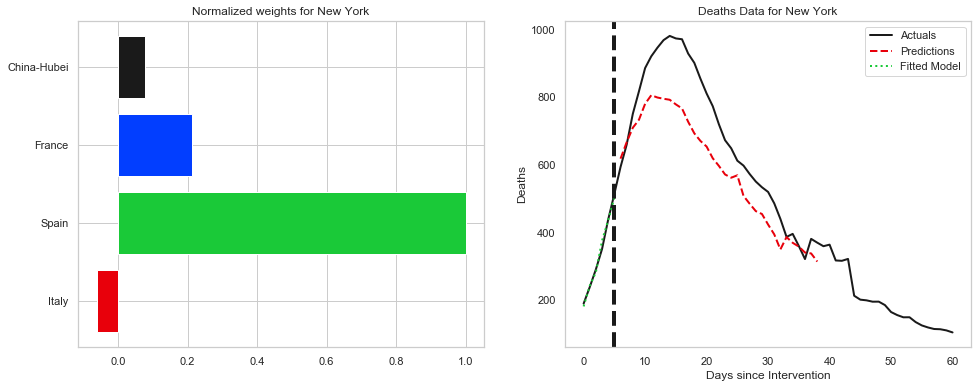

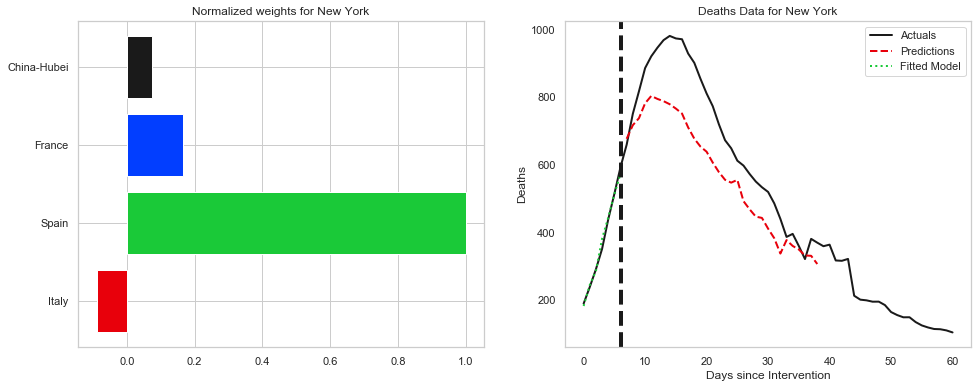

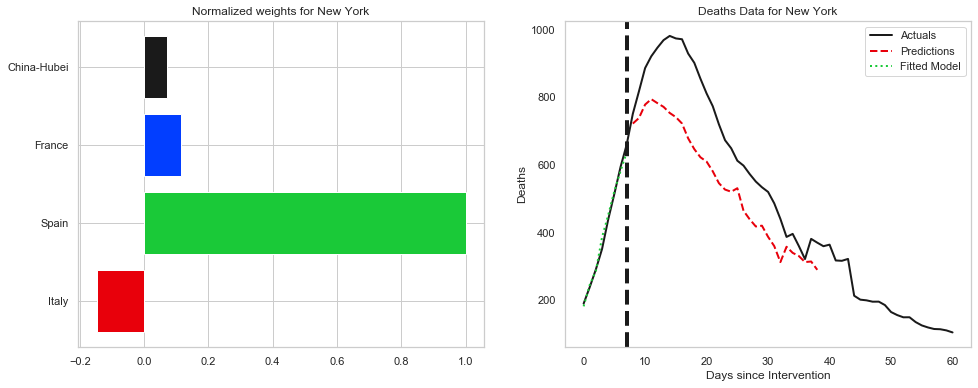

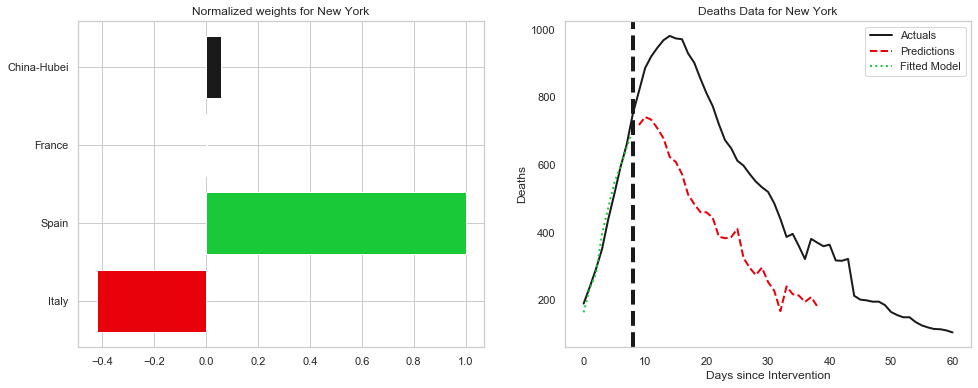

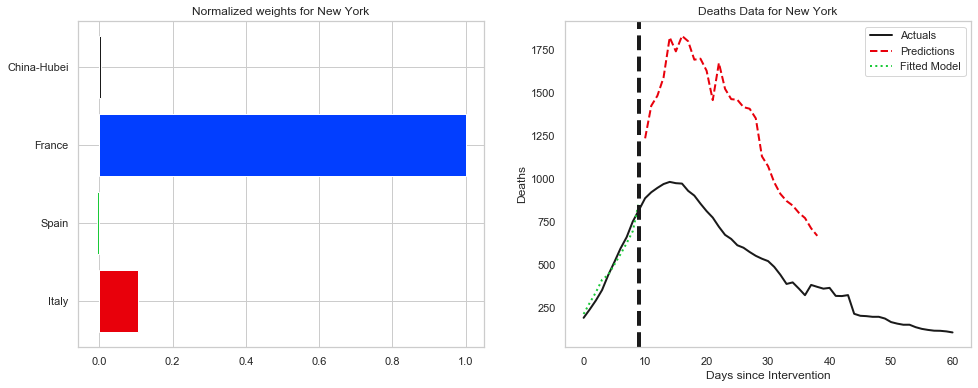

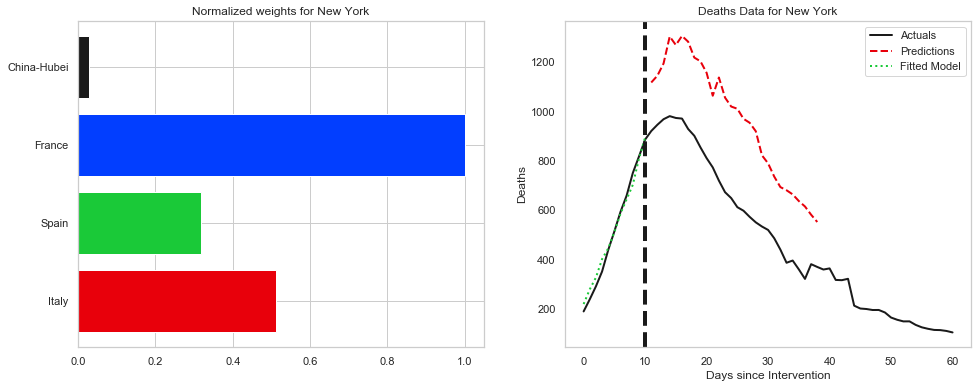

In [26]:
targets = ['New York']#, 'New York', 'Illinois', 'Belgium', 'Switzerland', 'New Jersey', 'France', 'Italy', 'United Kingdom']# 'Ohio', 'Sweden']
donorpool = ['Italy', 'Spain', 'France', 'China-Hubei']
singVals = 2

move_intervention = 10
for target in targets:
    fig = plt.figure(figsize=(16,6))
    camera = Camera(fig)
    for i in range(1,10):
        new_value = synth_control_predictions([deaths_intervention_adjusted_daily],40,2+i, "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=[], svdSpectrum=False, donorPool=donorpool, animation=camera, showDonors=True, silent=False )
    animation = camera.animate(interval=300)
HTML(animation.to_html5_video())
#animation.save('../animations/'+target+' predictions.mp4')
#temp_df = filter_data_by_intervention(all_data_daily[[target]], educational_distancing, move_intervention)
        #synth_control_predictions(pd.concat([deaths_intervention_adjusted_daily,temp_df], axis=1),45,25, "Deaths Data", 
                              #singVals, ylimit=[], savePlots=False, do_only=[target+" -"+str(move_intervention)], 
                              # showstates=10, svdSpectrum=False, showDonors=False,
                              # exclude=[target])
   

In [27]:
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

rolling_average_duration = 7
deaths_intervention_adjusted = filter_data_by_intervention(all_data, educational_distancing)
deaths_intervention_adjusted_daily = deaths_intervention_adjusted.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
deaths_intervention_adjusted_daily.index = deaths_intervention_adjusted_daily.index-rolling_average_duration

cases_intervention_adjusted = filter_data_by_intervention(all_data_cases, educational_distancing)
cases_intervention_adjusted_daily = cases_intervention_adjusted.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
cases_intervention_adjusted_daily.index = cases_intervention_adjusted_daily.index-rolling_average_duration


last date
Exceptions are []


In [28]:
df = deaths_intervention_adjusted_daily
df = df[df.columns[(df>10).any()]].copy()
lambdas=[1,0.01]
df1 = cases_intervention_adjusted_daily[df.columns].iloc[15:,:].copy()

#targets = [ 'New York', 'Illinois', 'Belgium', 'Switzerland', 'New Jersey', 'France', 'Italy', 'United Kingdom']# 'Ohio', 'Sweden']
#targets = newdf.columns
high_thresh = 55
low_thresh = 50
#targets = random.sample(list(deaths_intervention_adjusted_daily.columns),80)
targets = df.columns
sizes = df[targets].apply(pd.Series.last_valid_index)
targets = sizes[sizes>=low_thresh].index


donorpool = sizes[sizes>=high_thresh].index


print(targets)
print(donorpool)
singVals = 3
weight_features = []
move_intervention = 10
for target in targets:
  
    try:
        newdata = synth_control_predictions([df, df1],high_thresh, low_thresh,
                                            "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=[], svdSpectrum=False, silent=True, showDonors=False, showPlots=False, lambdas=lambdas, mRSC=False, error_thresh = 1)
        weight_features.append(newdata)
    except ValueError:
        print(target)
        continue
feature_list = pd.DataFrame((weight_features))
feature_list.index=targets
feature_list.fillna(0, inplace=True)
#feature_list = feature_list.apply(lambda x: x/x.max(), axis=1)
feature_columns = feature_list.columns
kmeans = KMeans(n_clusters=5)
y = kmeans.fit_predict(feature_list[feature_columns])
feature_list.insert((feature_list.shape[1]),'KMeans',y)
feature_list.groupby('KMeans').groups
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, cluster_selection_method='leaf')
clustering_labels = clusterer.fit_predict(feature_list[feature_columns])
feature_list['DB'] = clustering_labels
feature_list.groupby('DB').groups


Index(['Austria', 'Belgium', 'China-Hubei', 'Czechia', 'Denmark', 'Finland',
       'France', 'Germany', 'Hungary', 'India', 'Ireland', 'Italy',
       'Netherlands', 'Poland', 'Portugal', 'Romania', 'Spain', 'Sweden',
       'Switzerland', 'United Kingdom', 'Arizona', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia',
       'Illinois', 'Indiana', 'Louisiana', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'Ohio', 'Pennsylvania', 'Rhode Island',
       'Texas', 'Virginia', 'Washington', 'Wisconsin', 'King-Washington',
       'Los Angeles-California', 'New York City-New York'],
      dtype='object')
Index(['Austria', 'Belgium', 'China-Hubei', 'Czechia', 'Denmark', 'Finland',
       'France', 'Germany', 'Hungary', 'India', 'Ireland', 'Italy',
       'Netherlands', 'Portugal', 'Romania', 'Spain', 'Sweden', 'Switzerland',
       'United Kingd

{-1: Index(['Austria', 'Belgium', 'China-Hubei', 'France', 'Germany', 'India',
        'Ireland', 'Italy', 'Netherlands', 'Poland', 'Portugal', 'Spain',
        'Switzerland', 'United Kingdom', 'Connecticut', 'Illinois', 'Louisiana',
        'Massachusetts', 'Michigan', 'Mississippi', 'New Jersey', 'New York',
        'North Carolina', 'Pennsylvania', 'Washington', 'Wisconsin',
        'Los Angeles-California', 'New York City-New York'],
       dtype='object'),
 0: Index(['Sweden', 'California'], dtype='object'),
 1: Index(['Indiana', 'Maryland', 'Ohio'], dtype='object'),
 2: Index(['Florida', 'Georgia', 'Texas'], dtype='object'),
 3: Index(['Romania', 'Arizona', 'Colorado', 'Minnesota', 'Virginia'], dtype='object'),
 4: Index(['Finland', 'Delaware', 'District of Columbia', 'New Mexico',
        'Rhode Island'],
       dtype='object'),
 5: Index(['Czechia', 'Hungary'], dtype='object'),
 6: Index(['Denmark', 'King-Washington'], dtype='object')}

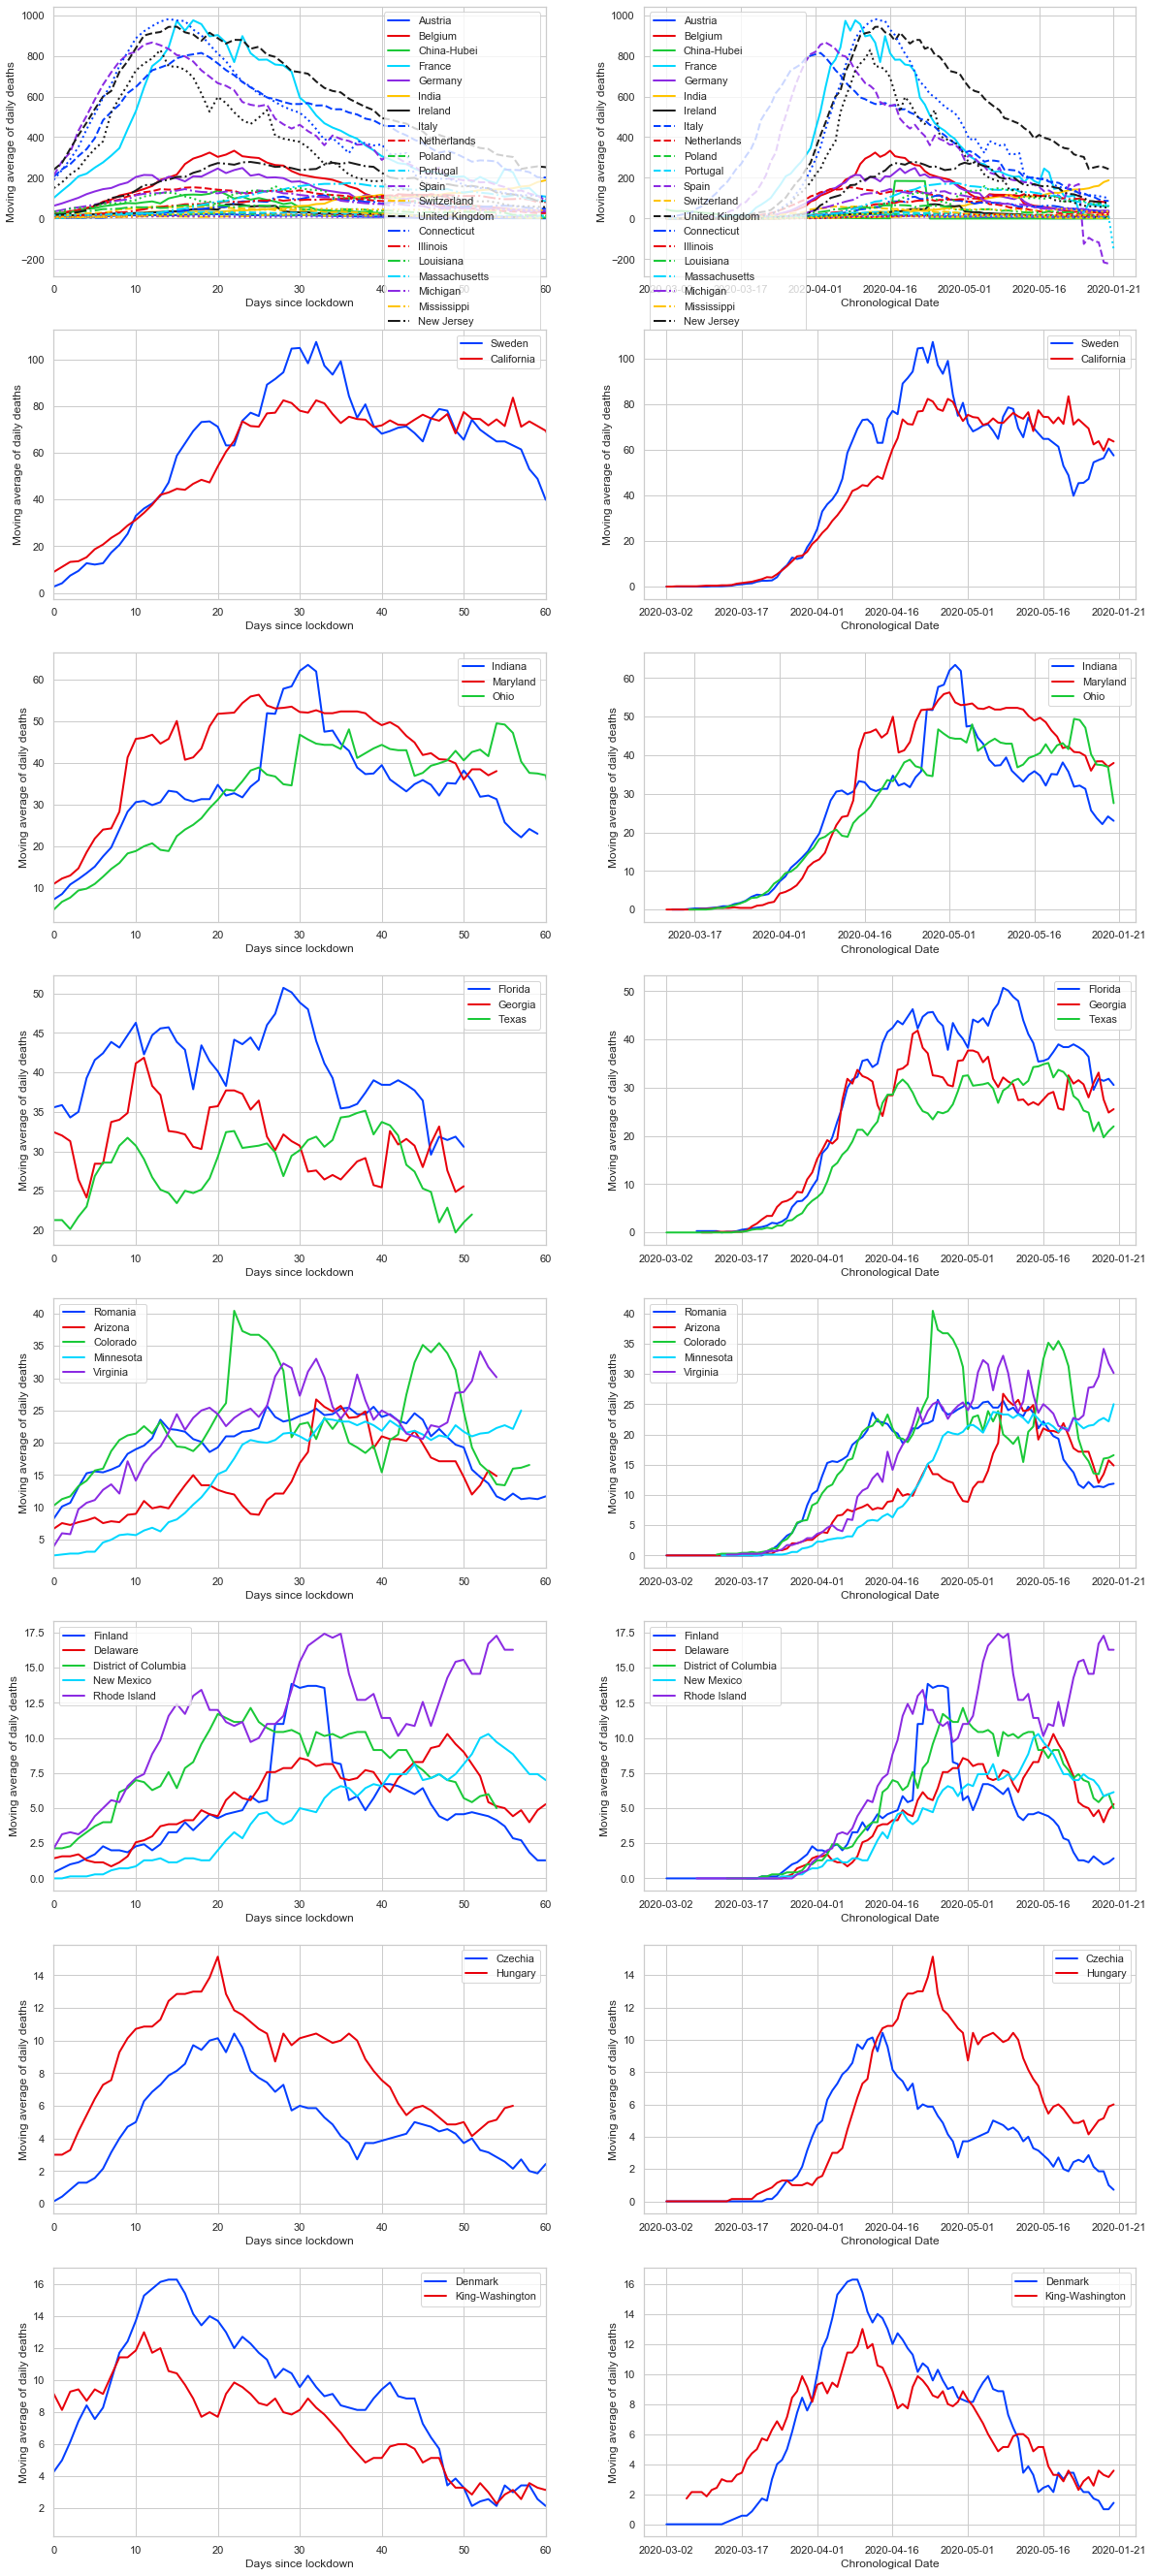

In [29]:
num_groups = len(feature_list.groupby('DB').groups)
plt.rcParams.update({'font.size': 8})
plt.rcParams['figure.figsize'] = (20.0, num_groups*6.0)
group1 = list(feature_list.groupby('DB').groups[-1])
for i in range(num_groups):
    group = (list(feature_list.groupby('DB').groups[i-1]))
    ax = plt.subplot(num_groups,2,2*i+1)

    df[group].plot(ax = ax, xlim=[0,60]), plt.legend(), plt.xlabel('Days since lockdown'), plt.ylabel('Moving average of daily deaths')
    ax = plt.subplot(num_groups,2,2*i+2)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
    all_data_daily[group].loc['2020-03-02':,:].plot(ax = ax), plt.legend(), plt.xlabel('Chronological Date'), plt.ylabel('Moving average of daily deaths')

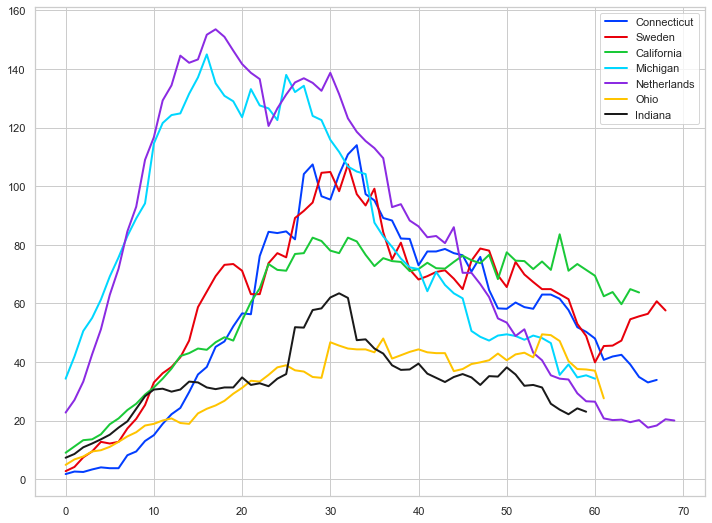

In [30]:
plt.rcParams['figure.figsize'] = (12,9.0)
plt.rcParams.update({'font.size': 12})


targets = ['Connecticut', 'Sweden', 'California', 'Michigan', 'Netherlands', 'Ohio', 'Indiana']
deaths_intervention_adjusted_daily[targets].plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x11c672f70>,
 Text(0.5, 0, 'Chronological Date'),
 Text(0, 0.5, 'Moving average of daily deaths'))

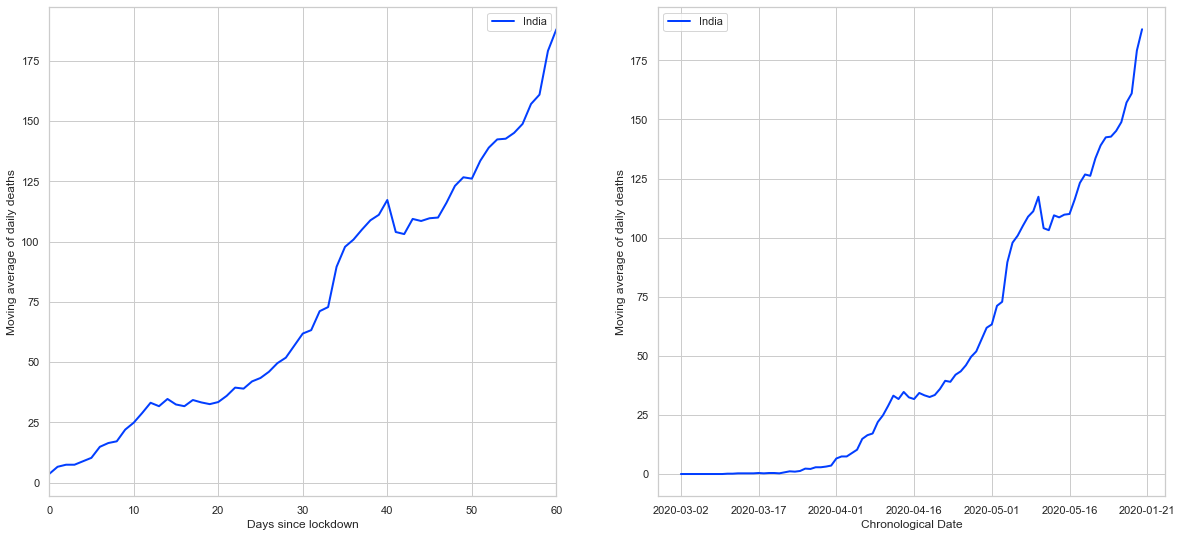

In [31]:
plt.rcParams['figure.figsize'] = (20,9.0)

group=['India']
ax = plt.subplot(1,2,1)

df[group].plot(ax = ax, xlim=[0,60]), plt.legend(), plt.xlabel('Days since lockdown'), plt.ylabel('Moving average of daily deaths')
ax = plt.subplot(1,2,2)
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
all_data_daily[group].loc['2020-03-02':,:].plot(ax = ax), plt.legend(), plt.xlabel('Chronological Date'), plt.ylabel('Moving average of daily deaths')

[0.025]


{-1: Index(['Belgium', 'China-Hubei', 'France', 'Germany', 'India', 'Ireland',
        'Italy', 'Netherlands', 'Spain', 'Sweden', 'United Kingdom',
        'California', 'Connecticut', 'Illinois', 'Massachusetts', 'Michigan',
        'New Jersey', 'New York', 'Pennsylvania', 'New York City-New York'],
       dtype='object'),
 0: Index(['Austria', 'Czechia', 'Denmark', 'Finland', 'Hungary', 'Poland',
        'Portugal', 'Romania', 'Switzerland', 'Arizona', 'Colorado', 'Delaware',
        'District of Columbia', 'Florida', 'Georgia', 'Louisiana', 'Minnesota',
        'Mississippi', 'New Mexico', 'North Carolina', 'Rhode Island', 'Texas',
        'Virginia', 'Washington', 'Wisconsin', 'King-Washington'],
       dtype='object'),
 1: Index(['Indiana', 'Maryland', 'Ohio', 'Los Angeles-California'], dtype='object')}

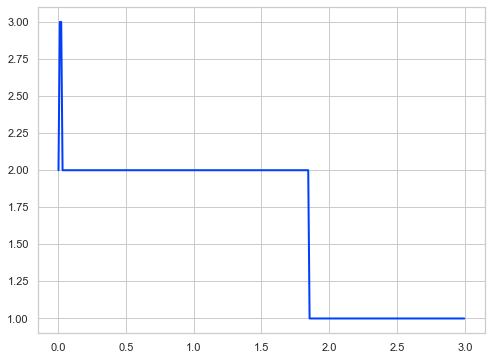

In [32]:
clusters = []
epsilon_range = np.arange(0.005,3,0.01)
for epsilon in epsilon_range:
    clustering = DBSCAN(eps=epsilon, min_samples=4).fit(feature_list[feature_columns].values)
    clusters.append(len(np.unique(clustering.labels_)))
plt.rcParams['figure.figsize'] = (8, 6)
plt.plot(epsilon_range, clusters)

eps = epsilon_range[np.argmax(clusters)]
eps = epsilon_range[random.choice(np.argwhere(clusters == np.amax(clusters)))]
print(eps)
#eps=.28
clustering = DBSCAN(eps=eps, min_samples=4).fit(feature_list[feature_columns].values)    
try:
    feature_list['DB'] = clustering.labels_
except KeyError:
    feature_list.insert((feature_list.shape[1]),'DB',clustering.labels_)
feature_list.groupby('DB').groups

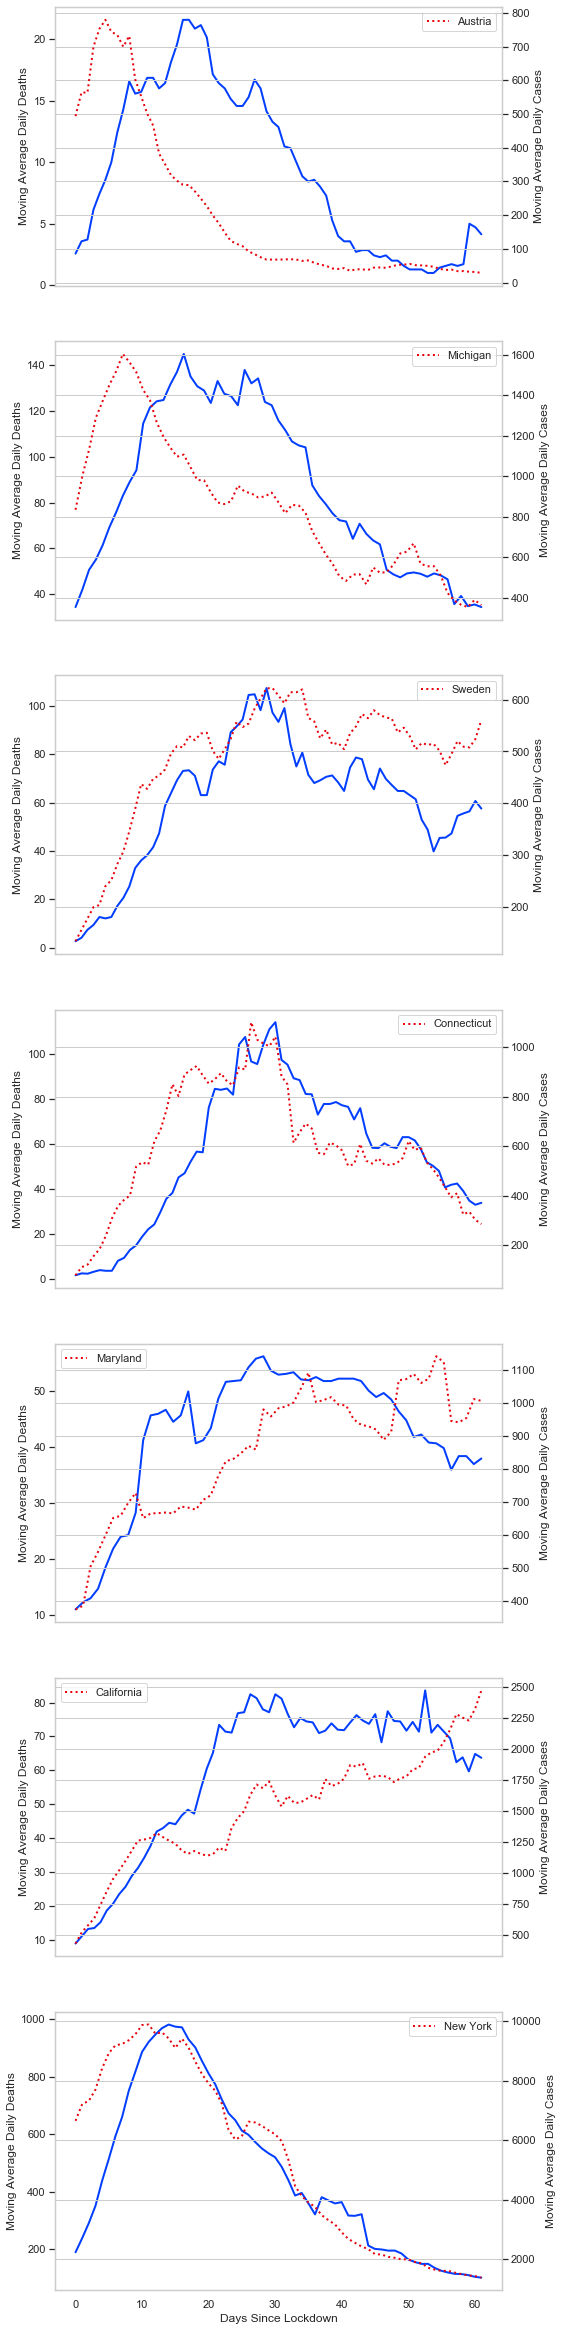

In [33]:
plt.rcParams.update({'font.size': 14})
list_of_clusters = ['Austria', 'Michigan', 'Sweden', 'Connecticut', 'Maryland', 'California', 'New York']
num_clusters = len(list_of_clusters)
plt.rcParams['figure.figsize'] = (8.0, num_clusters*6.0)

i=1
for clusters in list_of_clusters:
    ax = plt.subplot(num_clusters,1,i)
    deaths_intervention_adjusted_daily[clusters].plot(ax=ax), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths'), 
    cases_intervention_adjusted_daily[clusters].plot(ax=ax, linestyle=":", secondary_y=True), plt.ylabel('Moving Average Daily Cases'), plt.legend(),
    plt.xticks(rotation=45)
    i = i+1
                                                                                                

((array([ 0., 10., 20., 30., 40., 50., 60.]),
  <a list of 7 Text xticklabel objects>),
 Text(0.5, 0, 'Days Since Lockdown'),
 Text(0, 0.5, 'Moving Average Daily Deaths'))

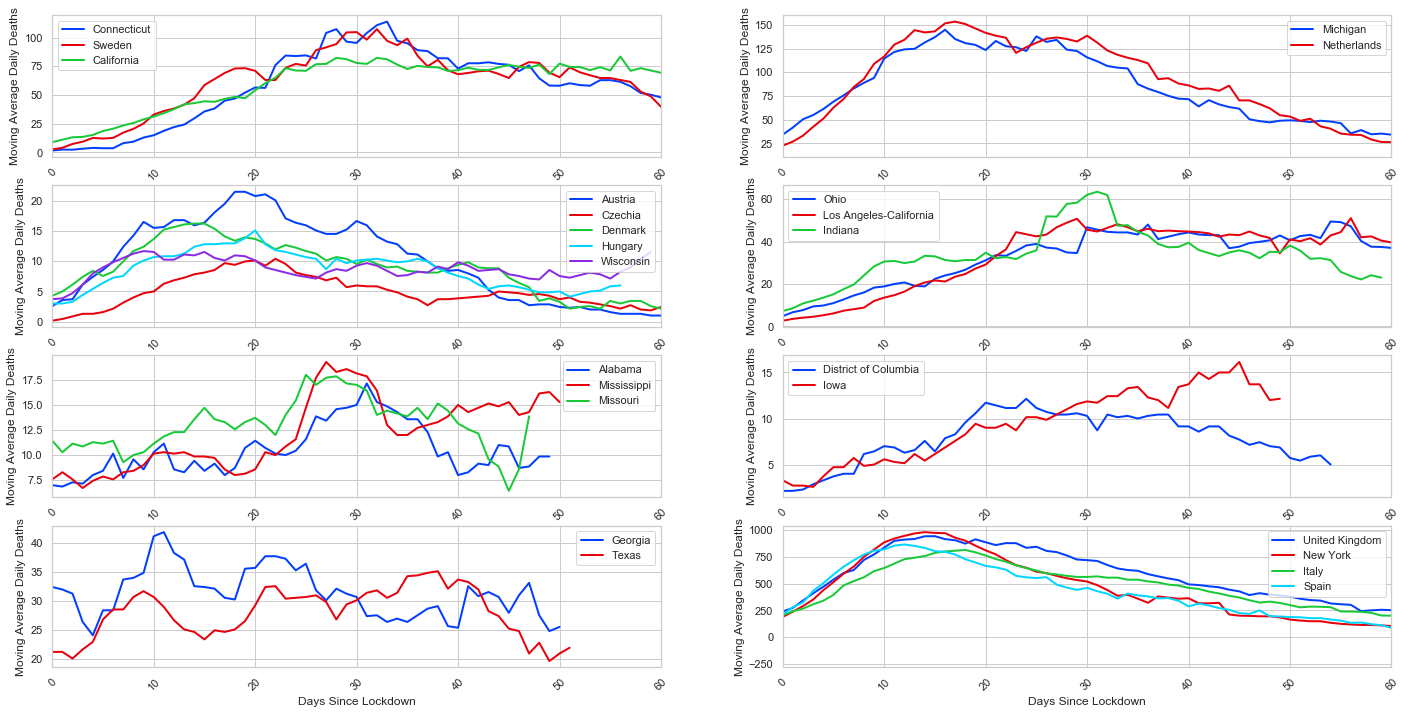

In [34]:
plt.rcParams['figure.figsize'] = (24.0, 12.0)
ax = plt.subplot(4,2,1)

deaths_intervention_adjusted_daily[['Connecticut', 'Sweden', 'California' ]].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(4,2,2)

deaths_intervention_adjusted_daily[['Michigan', 'Netherlands']].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(4,2,3)
deaths_intervention_adjusted_daily[['Austria', 'Czechia', 'Denmark', 'Hungary','Wisconsin']].plot(ax=ax), plt.xlim(0,60),

#deaths_intervention_adjusted_daily[['Ireland', 'Colorado']].plot(ax=ax), 

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(4,2,4)

deaths_intervention_adjusted_daily[['Ohio', 'Los Angeles-California', 'Indiana']].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

plt.plot()
ax = plt.subplot(4,2,5)

deaths_intervention_adjusted_daily[['Alabama', 'Mississippi', 'Missouri' ]].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(4,2,6)

deaths_intervention_adjusted_daily[['District of Columbia', 'Iowa']].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(4,2,7)

deaths_intervention_adjusted_daily[['Georgia', 'Texas']].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(4,2,8)

deaths_intervention_adjusted_daily[[ 'United Kingdom', 'New York', 'Italy', 'Spain']].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

((array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
  <a list of 9 Text xticklabel objects>),
 Text(0.5, 0, 'Days Since Lockdown'),
 Text(0, 0.5, 'Moving Average Daily Deaths'))

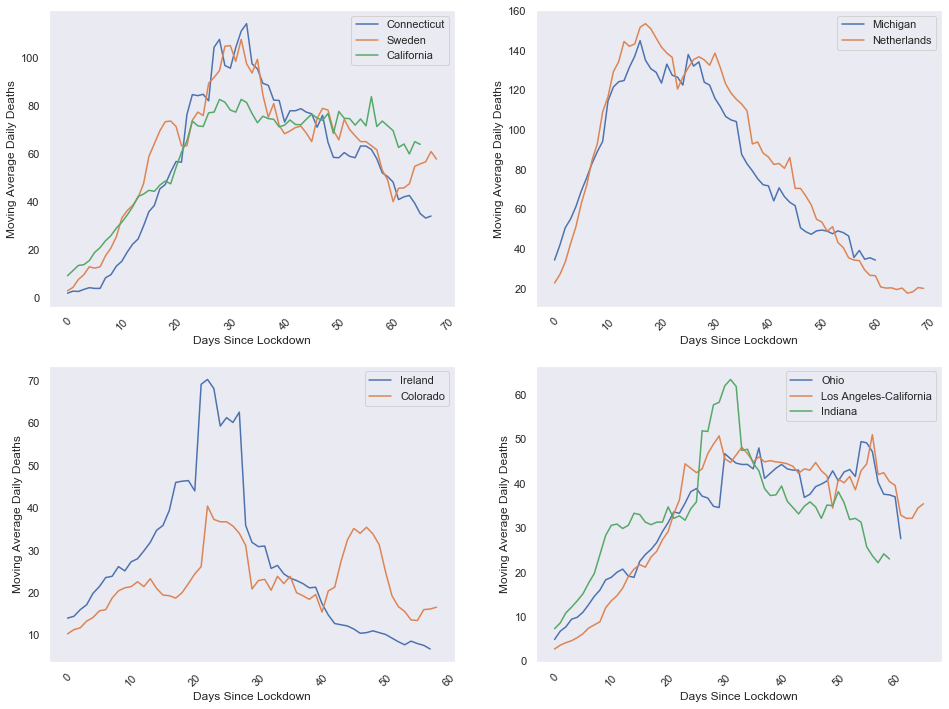

In [35]:
sns.set()
plt.rcParams['figure.figsize'] = (16.0, 12.0)
ax = plt.subplot(2,2,1)

deaths_intervention_adjusted_daily[['Connecticut', 'Sweden', 'California' ]].plot(ax=ax), plt.grid(),
plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(2,2,2)

deaths_intervention_adjusted_daily[['Michigan', 'Netherlands']].plot(ax=ax), plt.grid(), 
plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(2,2,3)

deaths_intervention_adjusted_daily[['Ireland', 'Colorado']].plot(ax=ax), plt.grid(), 
plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(2,2,4)

deaths_intervention_adjusted_daily[['Ohio', 'Los Angeles-California', 'Indiana']].plot(ax=ax), plt.grid(), 
plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

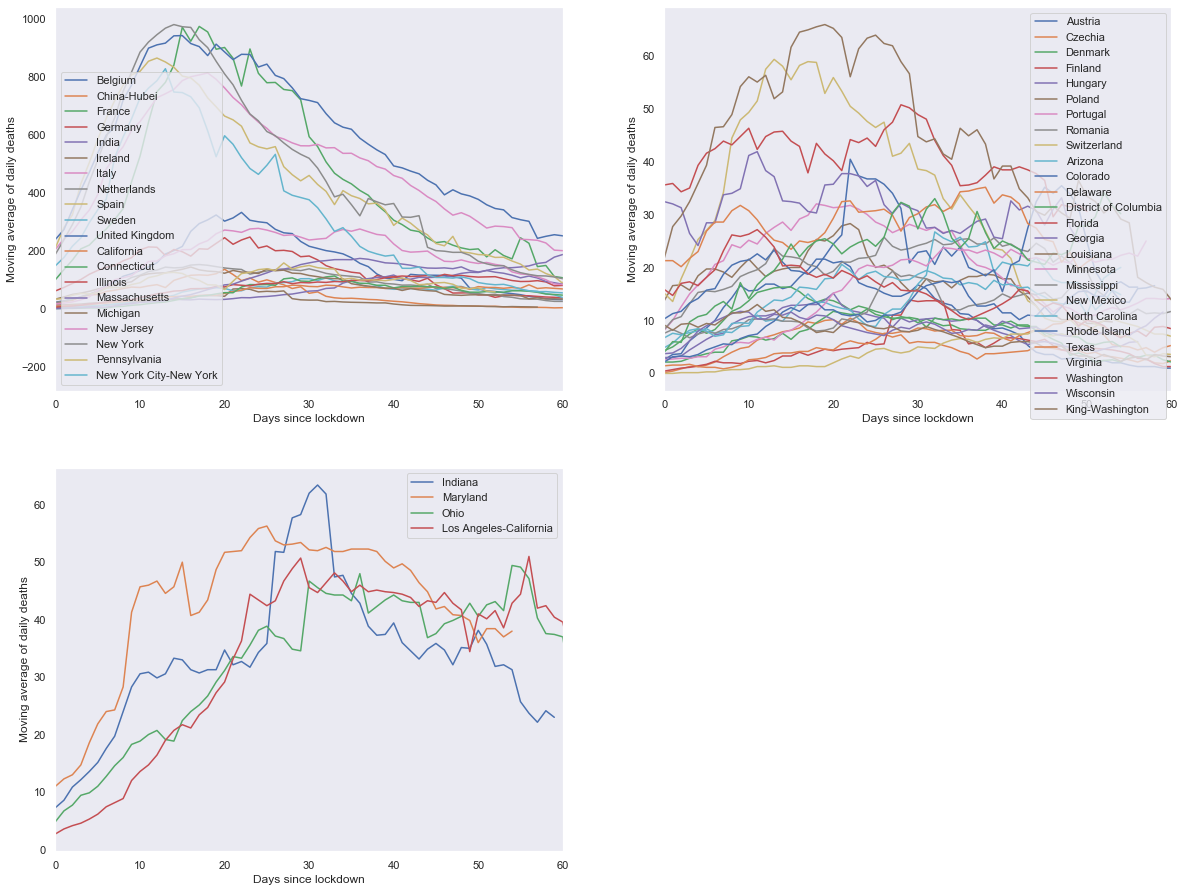

In [36]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.figsize'] = (20.0, 24.0)
plt.xlim([0,60])
for i in range(len(feature_list.groupby('DB').groups)):
    ax = plt.subplot(3,2,i+1)
    plt.xlim([0,60])
    group = (list(feature_list.groupby('DB').groups[i-1]))
    df[group].plot(ax = ax), plt.legend(), plt.xlabel('Days since lockdown'), plt.ylabel('Moving average of daily deaths'),plt.grid()

In [37]:
high_thresh = 40
low_thresh = 35
targets = us_states
#excludelist = group2.copy()

sizes = deaths_intervention_adjusted_daily[targets].apply(pd.Series.last_valid_index)
targets = sizes[sizes>low_thresh].index
donorpool = sizes[sizes>high_thresh].index
print(targets)
print(donorpool)
singVals = 3
weight_features = []
move_intervention = 10
for target in targets:
  
    try:
        newdata = synth_control_predictions([deaths_intervention_adjusted_daily[targets]],high_thresh, low_thresh,
                                            "Daily Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                              svdSpectrum=False, silent=True, showDonors=False, mRSC=False, showPlots=False)
        #newdata = synth_control_predictions(deaths_intervention_adjusted_daily,high_thresh, low_thresh,
        #                                    "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
        #                       exclude=excludelist, svdSpectrum=False, silent=False, showDonors=False, donorPool=group1 )
        
    except ValueError:
        print(target)
        continue


NameError: name 'us_states' is not defined

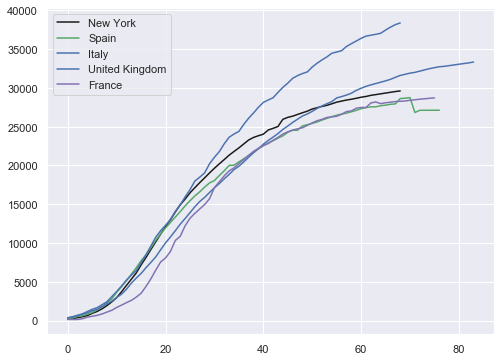

(Text(0.5, 0, 'Days since non-essential businesses shut down'),
 Text(0, 0.5, '5-day moving average of daily death count'),
 <matplotlib.legend.Legend at 0x11c54c070>)

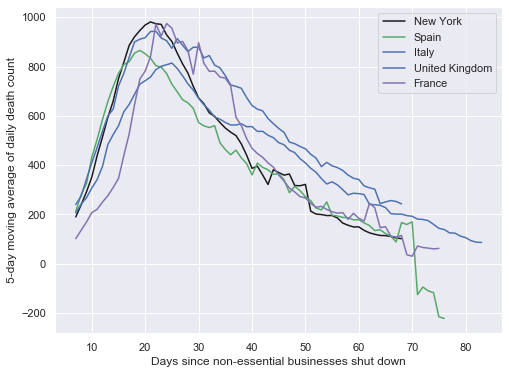

In [38]:
#plt.yscale('log')
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))

newdf['New York'].plot(color='k'), newdf_global['Spain'].plot(color='g'), newdf_global['Italy'].plot(),
newdf_global['United Kingdom'].plot(color='b'), newdf_global['France'].plot(color='m'), plt.legend()
plt.show()
plt.figure(figsize=(8,6))
daily_us['New York'].plot(color='k'), daily_global['Spain'].plot(color='g'), daily_global['Italy'].plot(),
daily_global['United Kingdom'].plot(color='b'), daily_global['France'].plot(color='m'),
plt.xlabel('Days since non-essential businesses shut down'), plt.ylabel('5-day moving average of daily death count'), plt.legend()

([None, None, None, None, None, None, None, None, None, None],
 <matplotlib.legend.Legend at 0x11b314df0>)

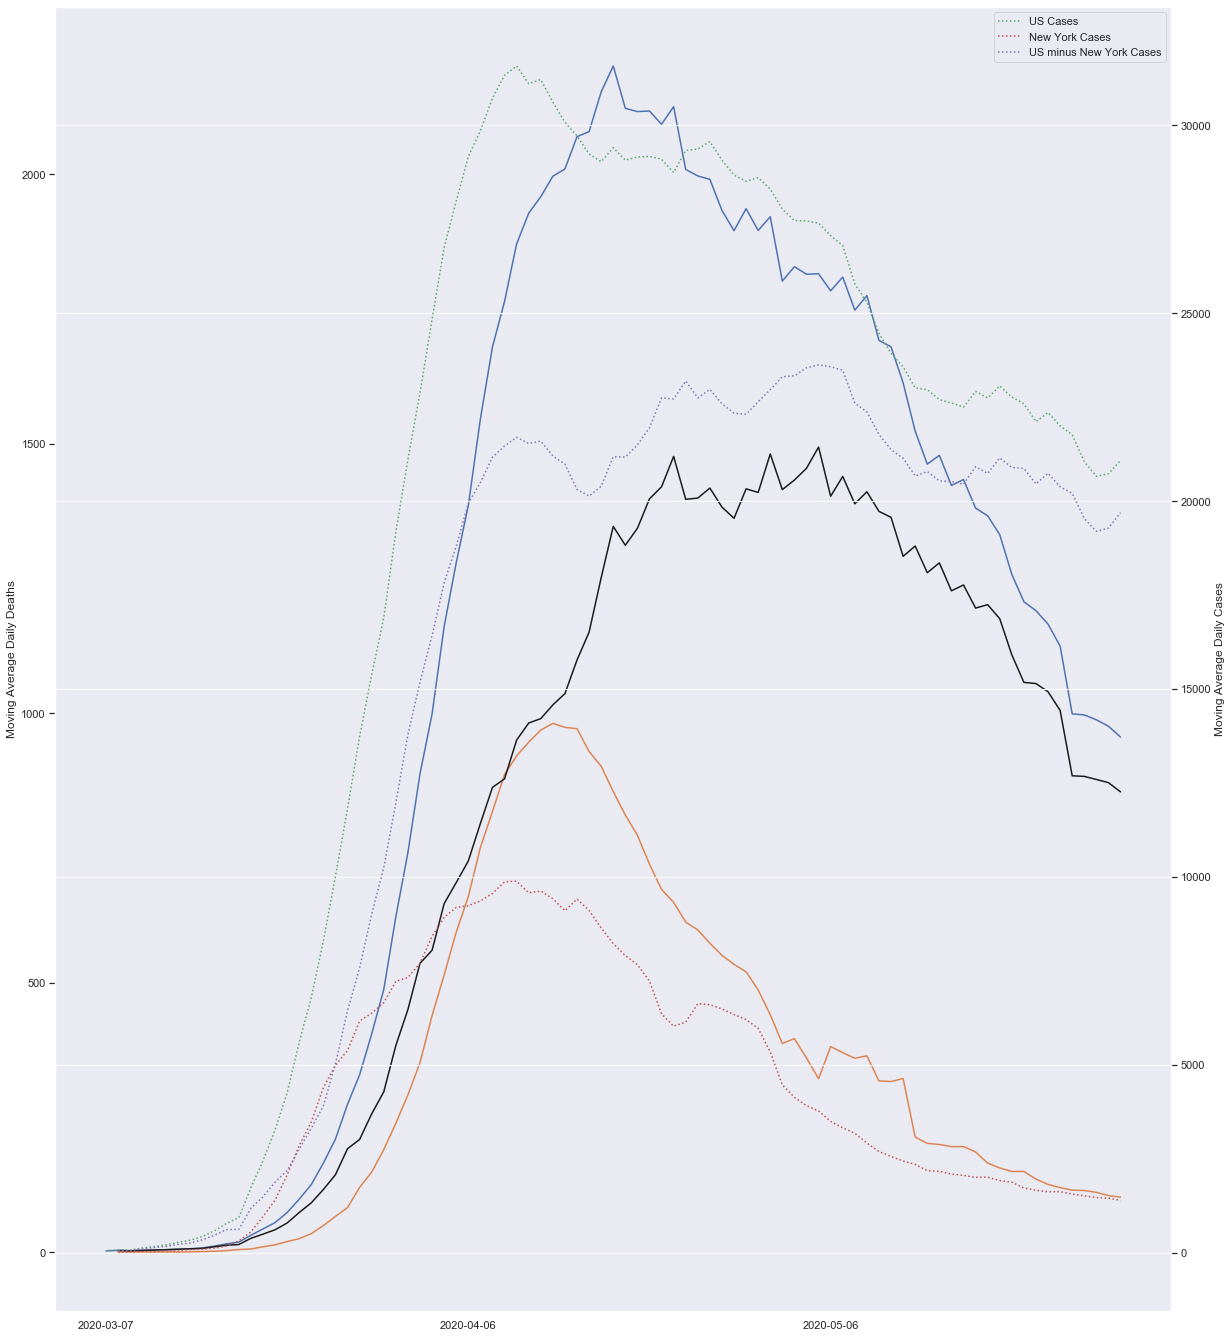

In [39]:
fig, ax = plt.subplots(1,1)
tick_spacing = 30
# this is a bug in matplotlib
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams.update({'font.size': 10})
label_markings = ax.get_xticklabels()
ax.set_xticklabels(label_markings, rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

tri_state = all_data_daily['New York']#+all_data_daily['New Jersey']+all_data_daily['Connecticut']
tri_state_cases = all_data_cases_daily['New York']#+all_data_daily['New Jersey']+all_data_daily['Connecticut']

plt.rcParams.update({'font.size': 14})
us_minus_new_york = all_data_daily['US'] - tri_state
us_minus_new_york_cases = all_data_cases_daily['US'] - tri_state_cases

all_data_daily['US'].loc['2020-03-07':].plot(ax=ax, label='US'), tri_state.loc['2020-03-07':].plot(ax=ax, label="New York"), 
us_minus_new_york.loc['2020-03-07':].plot(ax=ax,color='k', label="US minus New York"), plt.ylabel('Moving Average Daily Deaths'), 

all_data_cases_daily['US'].loc['2020-03-07':].plot(ax=ax, label='US Cases', secondary_y=True,linestyle=":"), 
tri_state_cases.loc['2020-03-07':].plot(ax=ax, label="New York Cases", secondary_y=True,linestyle=":"),  
us_minus_new_york_cases.loc['2020-03-07':].plot(ax=ax, label="US minus New York Cases", secondary_y=True,linestyle=":"), plt.legend(), plt.ylabel('Moving Average Daily Cases')
plt.setp( ax.get_xticklabels(), visible=True), plt.legend()
#deaths_intervention_adjusted_daily['Maryland'].plot(), deaths_intervention_adjusted_daily['Connecticut'].plot(), plt.legend(), plt.grid()



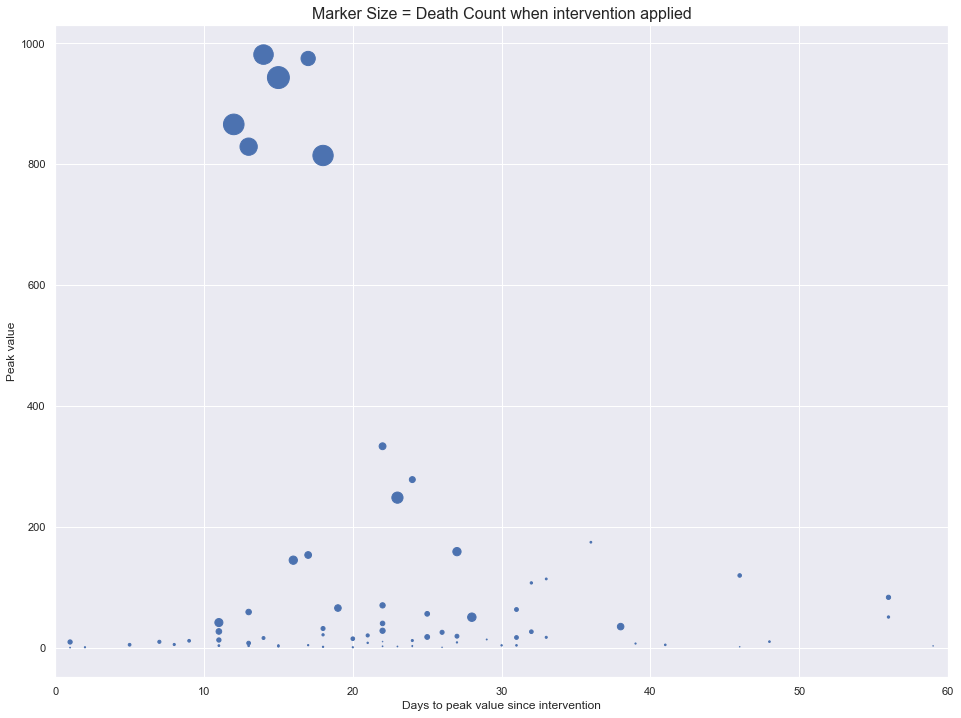

In [40]:
df = create_peak_clusters(deaths_intervention_adjusted_daily,7)
plt.figure(figsize=(16,12))
#fig, ax = plt.subplots(1,1)

plt.rcParams.update({'font.size': 12})
tick_spacing = 30
# this is a bug in matplotlib
#plt.rcParams['figure.figsize'] = (24.0, 18.0)

#label_markings = ax.get_xticklabels()
#ax.set_xticklabels(label_markings, rotation=45)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.xlim([0,60])
plt.scatter(df['days to peak'], (df['peak value']), s=2*df['initial value']),
#plt.scatter(global_peak_size_thresh['days to peak'], (global_peak_size_thresh['peak value']), s=2*global_peak_size_thresh['initial value'], color='r'), 
plt.xlabel('Days to peak value since intervention'), plt.title('Marker Size = Death Count when intervention applied', fontdict = {'fontsize' : 16}),
plt.ylabel('Peak value'),


variablelabel = df.index

for i, txt in enumerate(variablelabel):
    if(df['peak value'][i]>3500):
        plt.annotate(txt, (df['days to peak'][i], df['peak value'][i]+20))



(<matplotlib.axes._subplots.AxesSubplot at 0x11c46a910>,
 <matplotlib.legend.Legend at 0x11ca631f0>)

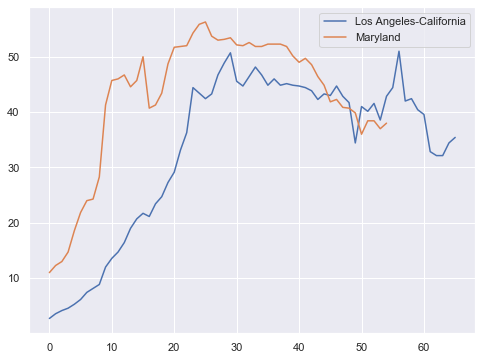

In [41]:

tick_spacing = 30
targets = ['Los Angeles-California', 'Maryland']
# this is a bug in matplotlib
df = deaths_intervention_adjusted_daily
plt.rcParams['figure.figsize'] = (8.0, 6.0)
df[targets].plot(), plt.legend()

16


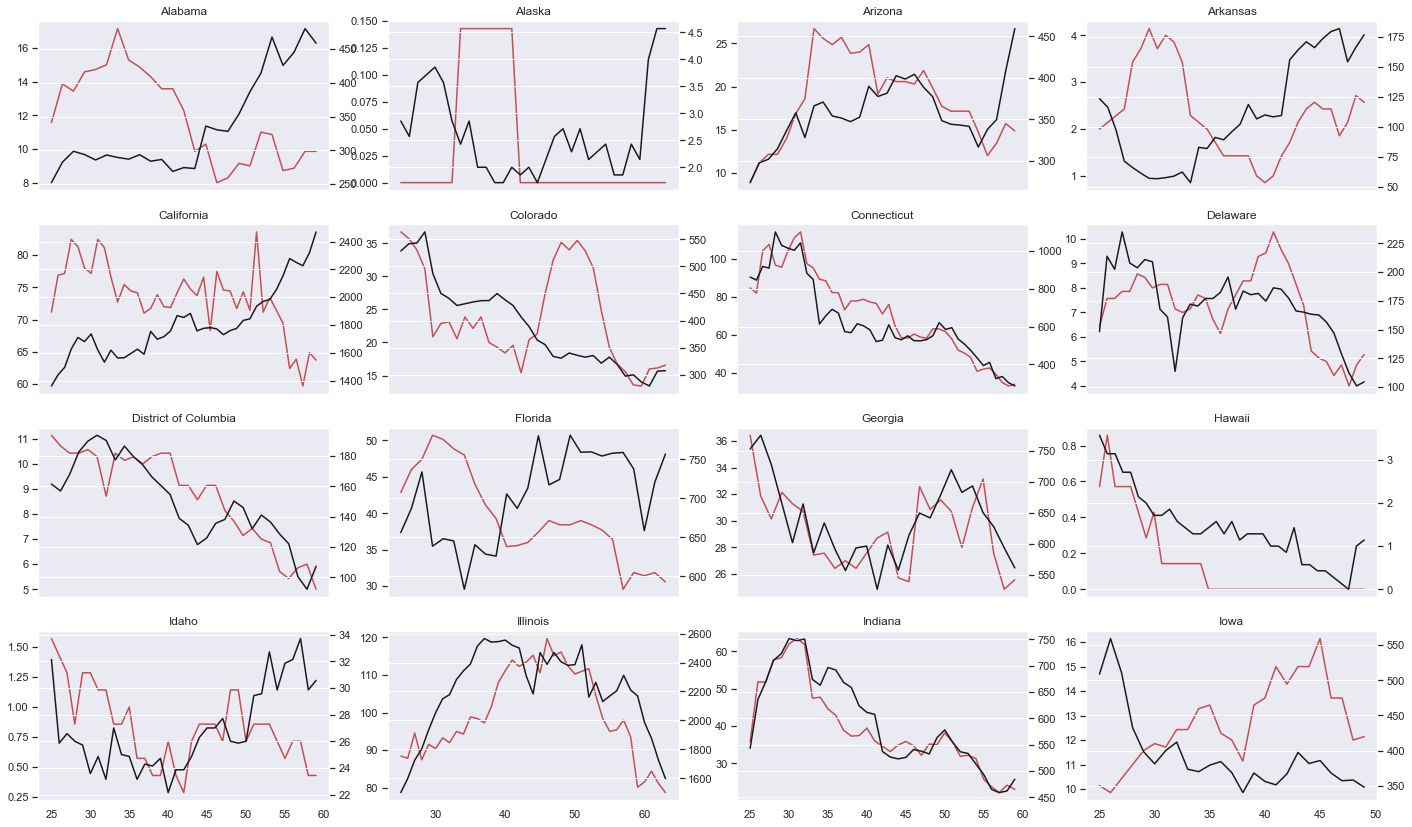

32


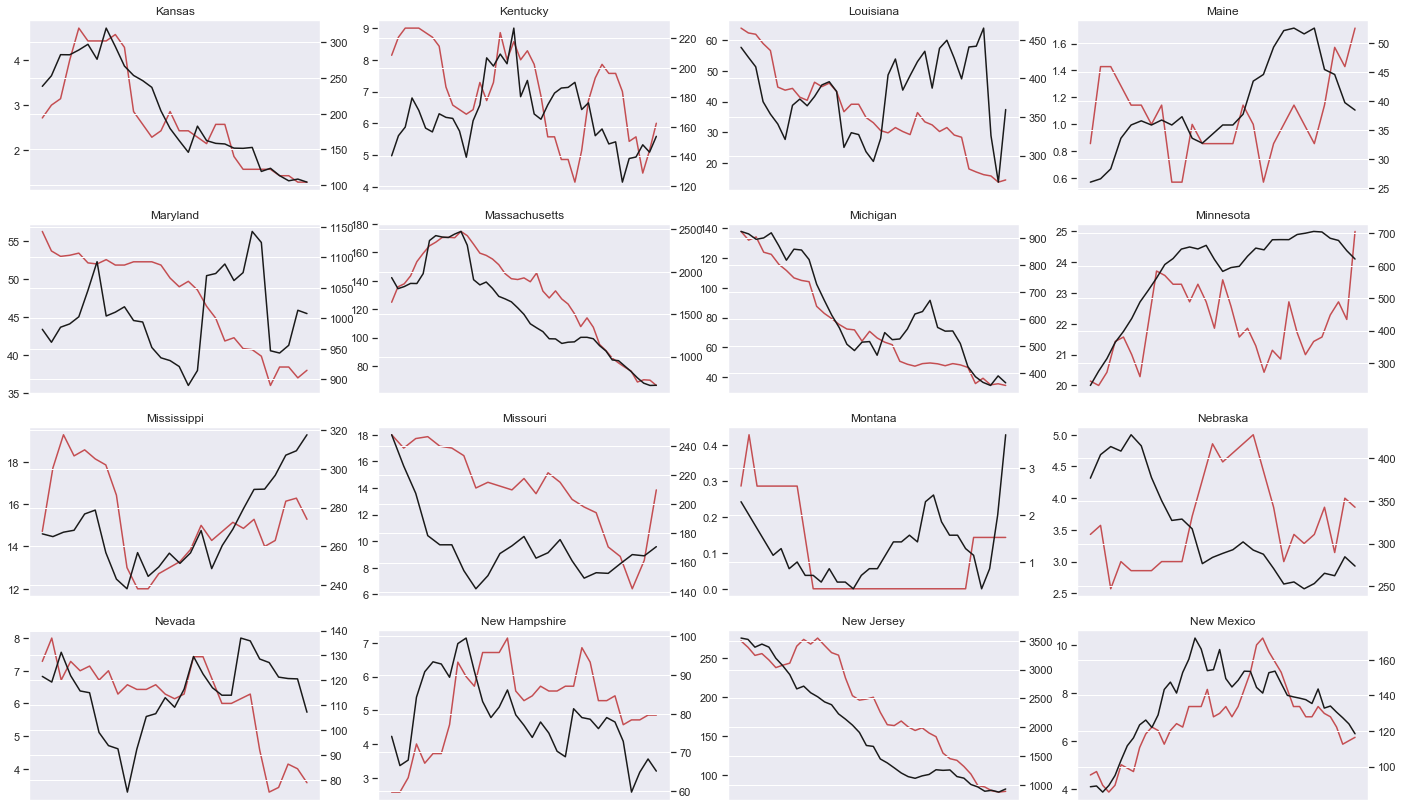

48


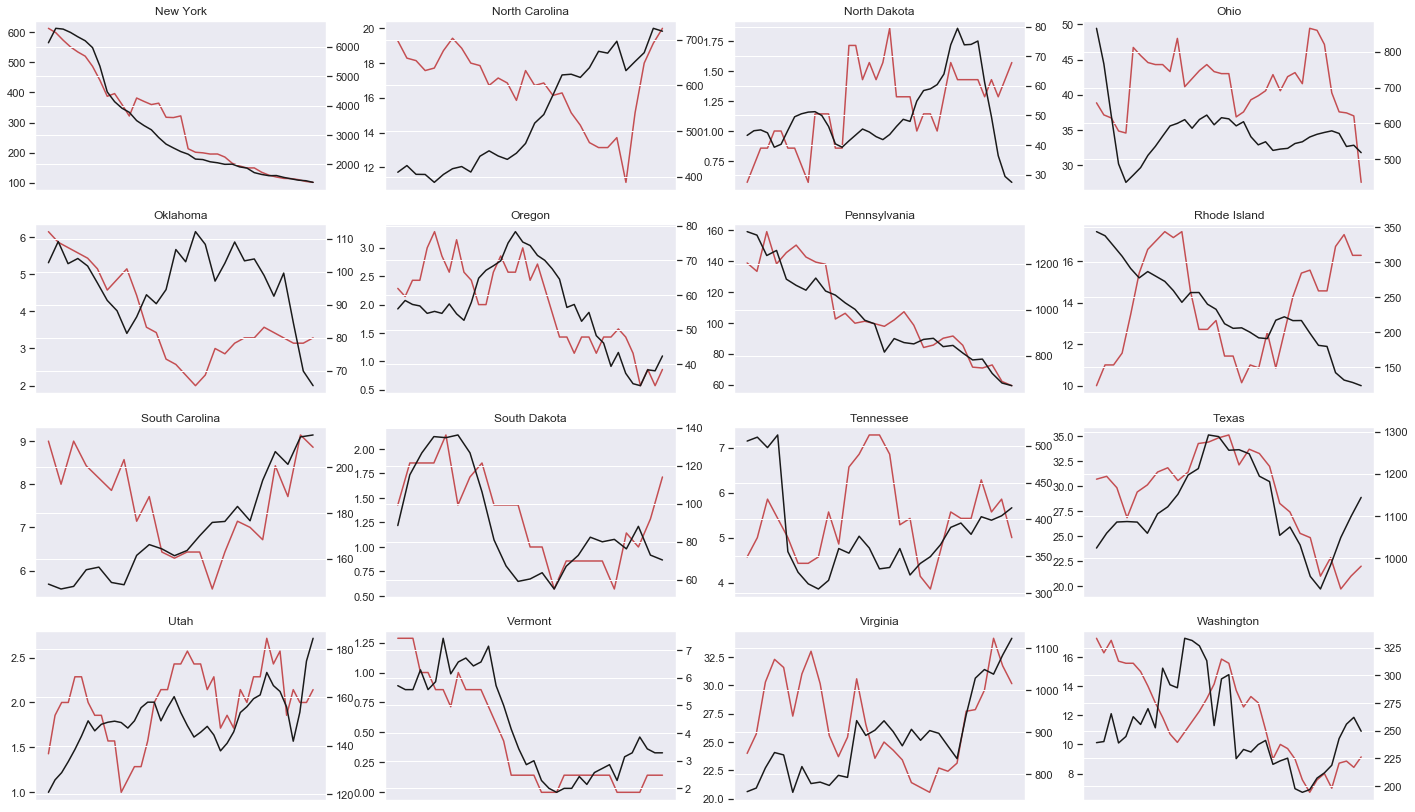

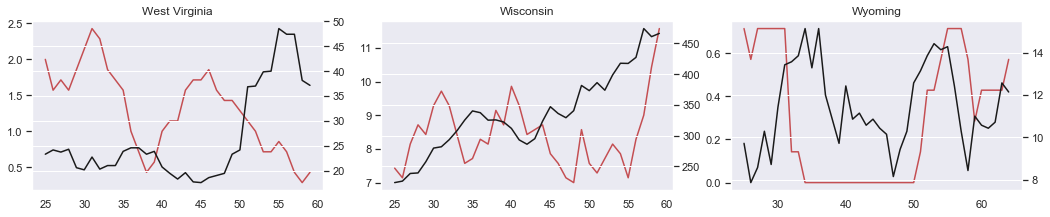

In [42]:
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = (24.0, 48.0)

plot_target = ['Sweden', 'Belgium', 'Netherlands', 'Spain', 'New York', 'Italy', 'Florida', 'India']
plot_us = [ 'Texas', 'Illinois','Maryland', 'Indiana', 'Virginia', 'Tennessee', 'North Carolina', 'Iowa', 'Arizona',
          'Wisconsin', 'South Carolina', 'Minnesota', 'Nebraska', 'Delaware', 'Kansas', 'New Mexico', 
           'New Hampshire', 'North Dakota', 'Florida', 'Michigan','Wyoming']
plot_us=newdf.columns
newfig=[16,32,48]
for i in range(1,52):

    ax = plt.subplot(13,4, i)
    deaths_intervention_adjusted_daily[plot_us[i-1]].iloc[25:].plot(ax = ax, color='r', label='deaths')
    #plt.legend()
    
    cases_intervention_adjusted_daily[plot_us[i-1]].iloc[25:].plot(ax = ax, secondary_y=True, color='k', label='cases')
    #plt.legend()
    plt.title(plot_us[i-1])
    if i in newfig:
        print(i)
        plt.show()


In [43]:
google_social = pd.DataFrame(data=global_google, columns= ['date'])

In [44]:
trial = filter_data_by_intervention(all_data, google_social)

AttributeError: 'DataFrame' object has no attribute 'name'

In [45]:
mobility_data_google[mobility_data_google.country_region =='United States'].sub_region_1.unique()


array([nan, 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [46]:
mobility_data_google.columns


Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'date', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

16


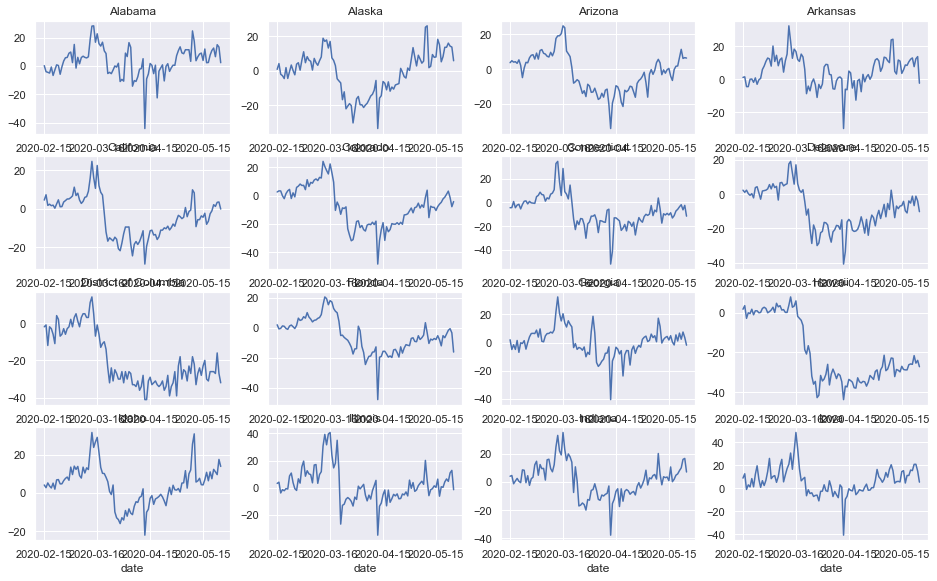

32


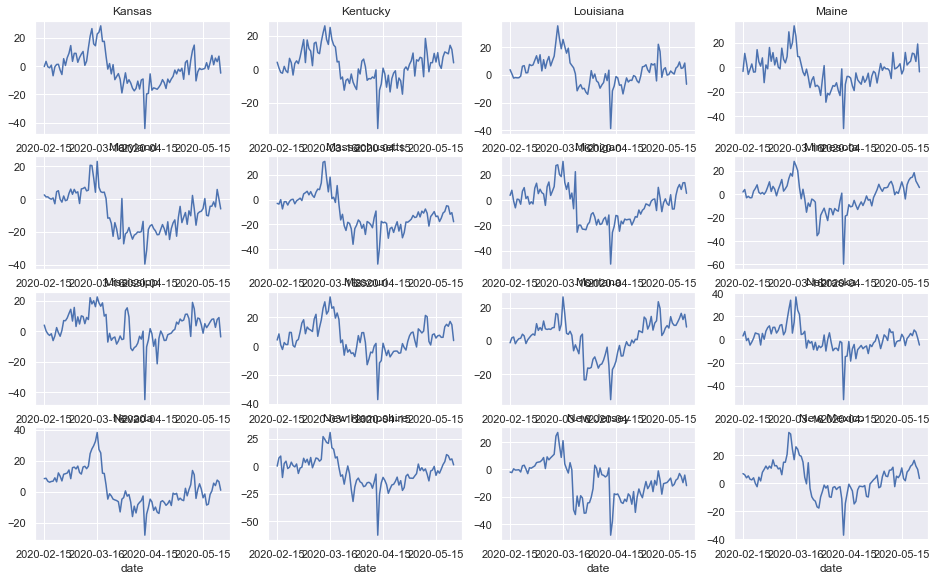

48


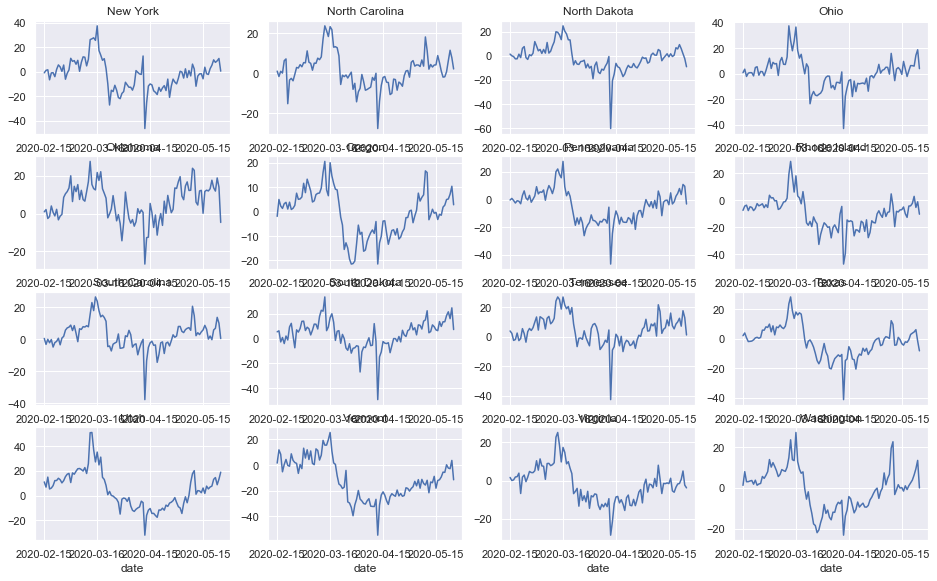

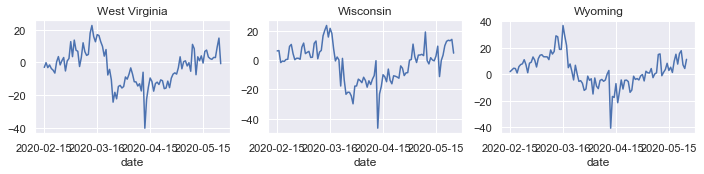

In [47]:
state_list = ['Massachusetts', 'New Jersey', 'New York', 'California', 'Washington']
state_list = newdf.columns
plt.rcParams['figure.figsize'] = (16.0, 32.0)

newfig=[16,32,48]

tick_spacing = 30
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

plt.setp( ax.get_xticklabels(), visible=False)

mobility_us = mobility_data_google.loc[mobility_data_google.country_region == 
                                       "United States"].pivot_table(index='date', values=mobility_data_google.columns[6], columns='sub_region_1')
for i in range(1,52):
    ax = plt.subplot(13,4, i)
    #plt.setp( ax.get_xticklabels(), visible=False)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


    mobility_us[state_list[i-1]].plot(ax=ax, title = state_list[i-1])
    if i in newfig:
        print(i)
        plt.show()

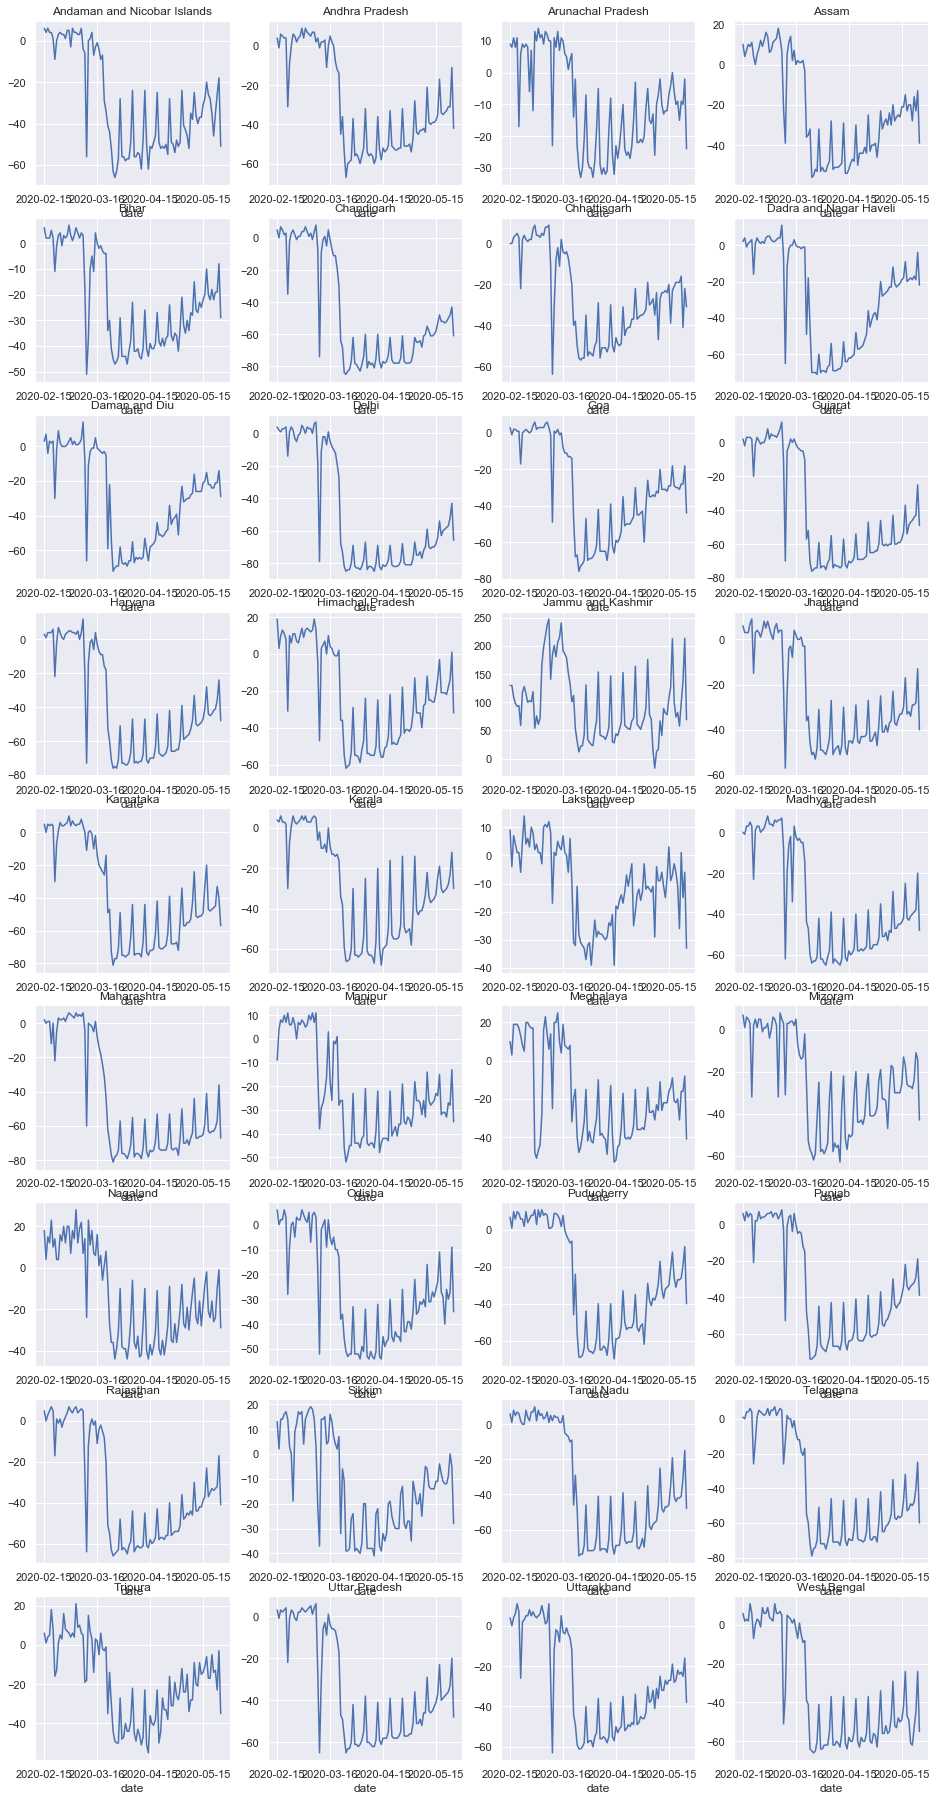

In [48]:
plt.rcParams['figure.figsize'] = (16.0, 32.0)
tick_spacing = 30
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

mobility_sweden = mobility_data_google.loc[mobility_data_google.country_region == 
                                       "India"].pivot_table(index='date', values=mobility_data_google.columns[9], columns='sub_region_1')
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
state_list=mobility_sweden.columns
total_figures = len(state_list)
num_rows = np.ceil(total_figures/4)
for i in range(1, total_figures+1):
    ax = plt.subplot(num_rows,4, i)
    plt.setp( ax.get_xticklabels(), visible=True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

    mobility_sweden[state_list[i-1]].plot(ax=ax, title = state_list[i-1])
#    if i in newfig:
#        print(i)
#        plt.show()

In [49]:
us_minus_newyork = all_data_daily['US'] - all_data_daily['New York']

(<matplotlib.legend.Legend at 0x11c9ca2e0>, None)

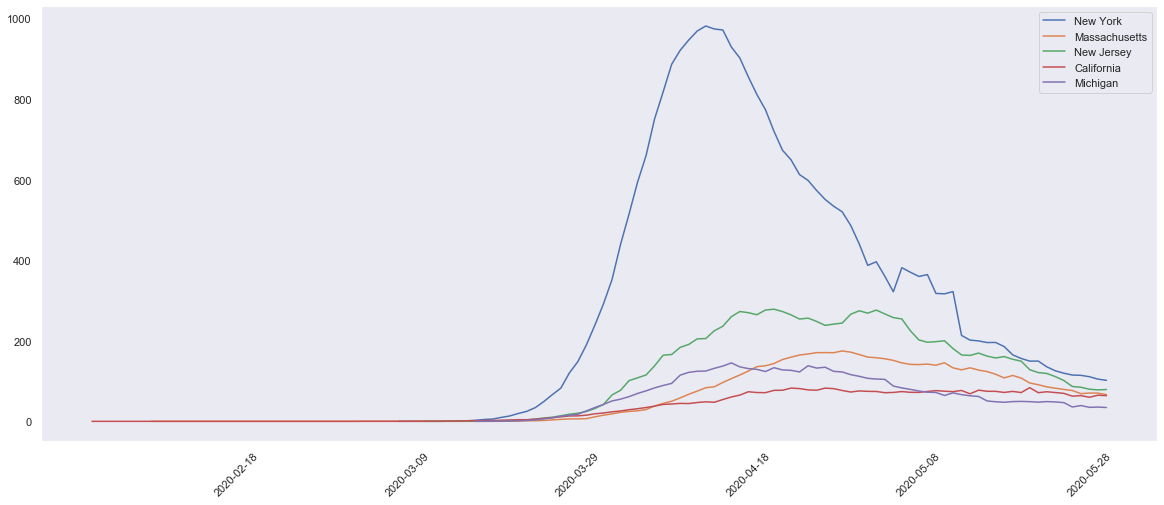

In [50]:
plt.rcParams['figure.figsize'] = (20.0, 8.0)

all_data_daily['New York'].plot(label="New York"),
all_data_daily['Massachusetts'].plot(), all_data_daily['New Jersey'].plot(),
all_data_daily['California'].plot(),
all_data_daily['Michigan'].plot(), plt.xticks(rotation=45),
plt.legend(), plt.grid()

# 

In [51]:
global_peak_size = create_peak_clusters(deaths_intervention_adjusted_daily)

In [52]:
def create_peak_clusters_date(df, threshold=5):
    df_temp = df
    df_cluster = pd.DataFrame(data=df_temp.idxmax(), columns=["days to peak"])
    df_cluster['sizes']=df_temp.apply(pd.Series.last_valid_index)
    df_cluster['peak value'] = df_temp.max()
    df_cluster['initial value'] = df_temp.iloc[0,:]
    df_cluster['sizes'] = df_cluster['sizes'].fillna(0)
    global_peak_size = df_cluster.loc[df_cluster['sizes'] - df_cluster['days to peak'] > threshold]
    #plt.scatter(global_peak_size['days to peak'], (global_peak_size['peak value']), s=2*global_peak_size['initial value']), 
    return global_peak_size

In [53]:
df_temp = all_data_daily
df_cluster = pd.DataFrame(data=df_temp.idxmax(), columns=["days to peak"])
df_cluster['sizes']=df_temp.apply(pd.Series.last_valid_index)
df_cluster['peak value'] = df_temp.max()
df_cluster['initial value'] = df_temp.iloc[0,:]
df_cluster['sizes'] = df_cluster['sizes'].fillna(0)
global_peak_size = df_cluster.loc[pd.to_datetime(df_cluster['sizes']) - pd.to_datetime(df_cluster['days to peak']) > pd.Timedelta('5 days')]

In [54]:
global_peak_size = create_peak_clusters(deaths_intervention_adjusted_daily)
global_peak_size_cases = create_peak_clusters(cases_intervention_adjusted_daily)

In [55]:
all_data_threshold = create_filtered_data(all_data, 5)

In [56]:
global_peak_size_thresh = create_peak_clusters(all_data_threshold.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:])

In [59]:
country_population = pd.read_excel("../data/country_pop_WDI.xlsx")
county_population = pd.read_excel("../data/co-est2019-annres.xlsx", header=[3])
new = county_population['Unnamed: 0'].str.replace(".","").str.replace(" County","").str.split(pat=",", expand=True)
county_population['state']=new[1].str.strip()
state_population = county_population.groupby('state').sum()
us_state_population = pd.DataFrame()
us_state_population['Country'] = state_population.index
us_state_population['Value'] = state_population[[2019]].values

all_population = pd.concat([country_population, us_state_population], axis=0, ignore_index=True)

FileNotFoundError: [Errno 2] No such file or directory: '../data/country_pop_WDI.xlsx'

In [53]:
county_population

Unnamed: 0       Census  \
0                                         United States  308745538.0   
1                              .Autauga County, Alabama      54571.0   
2                              .Baldwin County, Alabama     182265.0   
3                              .Barbour County, Alabama      27457.0   
4                                 .Bibb County, Alabama      22915.0   
...                                                 ...          ...   
3144  Note: The 6,222 people in Bedford city, Virgin...          NaN   
3145                                Suggested Citation:          NaN   
3146  Annual Estimates of the Resident Population fo...          NaN   
3147    Source: U.S. Census Bureau, Population Division          NaN   
3148                           Release Date: March 2020          NaN   

      Estimates Base         2010         2011         2012         2013  \
0        308758105.0  309321666.0  311556874.0  313830990.0  315993715.0   
1            54597.0      54773.0      55227.0      54954.0      54727.0   
2           182265.0     183112.0     186558.0     190145.0     194885.0   
3            27455.0      27327.0      27341.0      27169.0      26937.0   
4            22915.0      22870.0      22745.0      22667.0      22521.0   
...              ...          ...          ...          ...          ...   
3144             NaN          NaN          NaN          NaN          NaN   
3145             NaN          NaN          NaN          NaN          NaN   
3146             NaN          NaN          NaN          NaN          NaN   
3147             NaN          NaN          NaN          NaN          NaN   
3148             NaN          NaN          NaN          NaN          NaN   

             2014         2015         2016         2017         2018  \
0     318301008.0  320635163.0  322941311.0  324985539.0  326687501.0   
1         54893.0      54864.0      55243.0      55390.0      55533.0   
2        199183.0     202939.0     207601.0     212521.0     217855.0   
3         26755.0      26283.0      25806.0      25157.0      24872.0   
4         22553.0      22566.0      22586.0      22550.0      22367.0   
...           ...          ...          ...          ...          ...   
3144          NaN          NaN          NaN          NaN          NaN   
3145          NaN          NaN          NaN          NaN          NaN   
3146          NaN          NaN          NaN          NaN          NaN   
3147          NaN          NaN          NaN          NaN          NaN   
3148          NaN          NaN          NaN          NaN          NaN   

             2019                       state  
0     328239523.0                        None  
1         55869.0                     Alabama  
2        223234.0                     Alabama  
3         24686.0                     Alabama  
4         22394.0                     Alabama  
...           ...                         ...  
3144          NaN  222 people in Bedford city  
3145          NaN                        None  
3146          NaN              2010 to July 1  
3147          NaN         Population Division  
3148          NaN                        None  

[3149 rows x 14 columns]

NameError: name 'all_population' is not defined

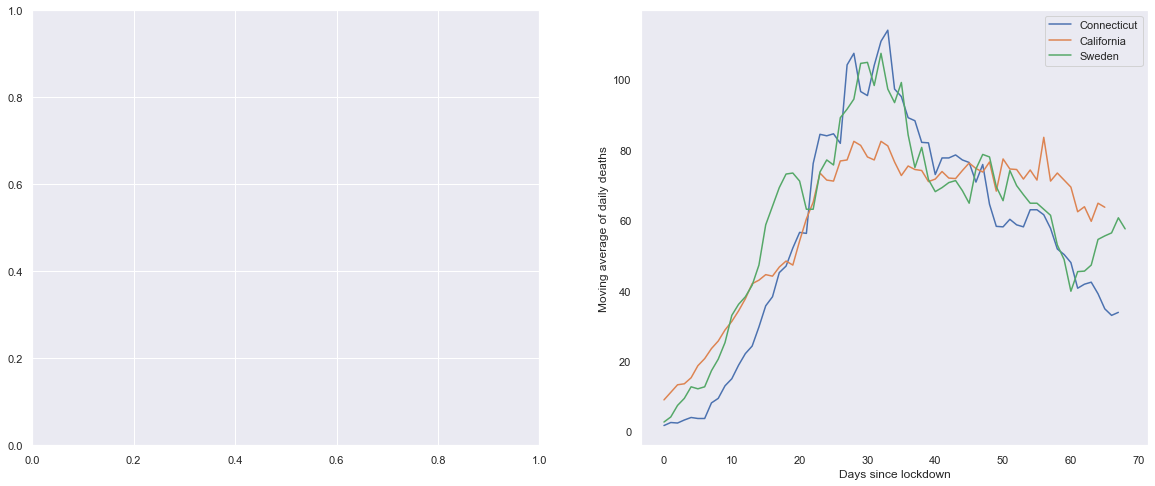

In [57]:
targets = ['Sweden', 'Denmark', 'Norway', 'Finland']
#targets = ['India', 'Russia', 'Brazil']
targets = ['Michigan', 'Netherlands']
targets = ['Connecticut', 'California', 'Sweden']

#targets = ['Austria', 'Czechia', 'Hungary']
plt.rcParams['figure.figsize'] = (20.0, 8.0)
ax = plt.subplot(1,2,2)
deaths_intervention_adjusted_daily[targets].plot(ax = ax), plt.xlabel('Days since lockdown'), plt.ylabel('Moving average of daily deaths'), plt.grid()
#plt.show()
ax = plt.subplot(1,2,1)
plt.barh(all_population[all_population.Country.isin(targets)].Country, all_population[all_population.Country.isin(targets)].Value, 
         color=list('bgrcyk')),plt.xlabel('Population')

NameError: name 'all_population' is not defined

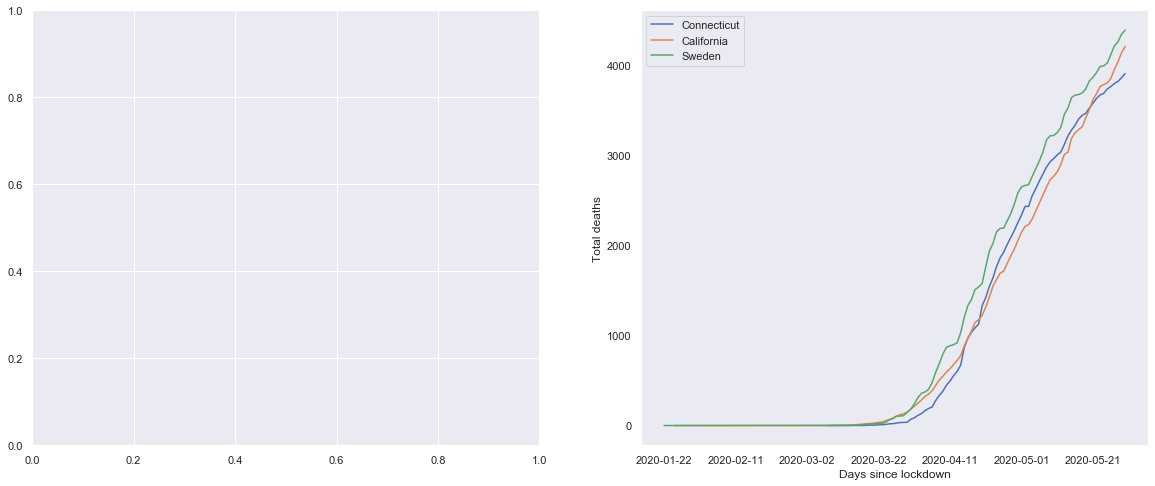

In [58]:
ax = plt.subplot(1,2,2)
all_data[targets].plot(ax = ax), plt.xlabel('Days since lockdown'), plt.ylabel('Total deaths'), plt.grid()
#plt.show()
ax = plt.subplot(1,2,1)
plt.barh(all_population[all_population.Country.isin(targets)].Country, all_population[all_population.Country.isin(targets)].Value, 
         color=list('bgrcyk')),plt.xlabel('Population')


In [60]:
new[1].str.strip()

NameError: name 'new' is not defined

(<matplotlib.axes._subplots.AxesSubplot at 0x11d402340>, None)

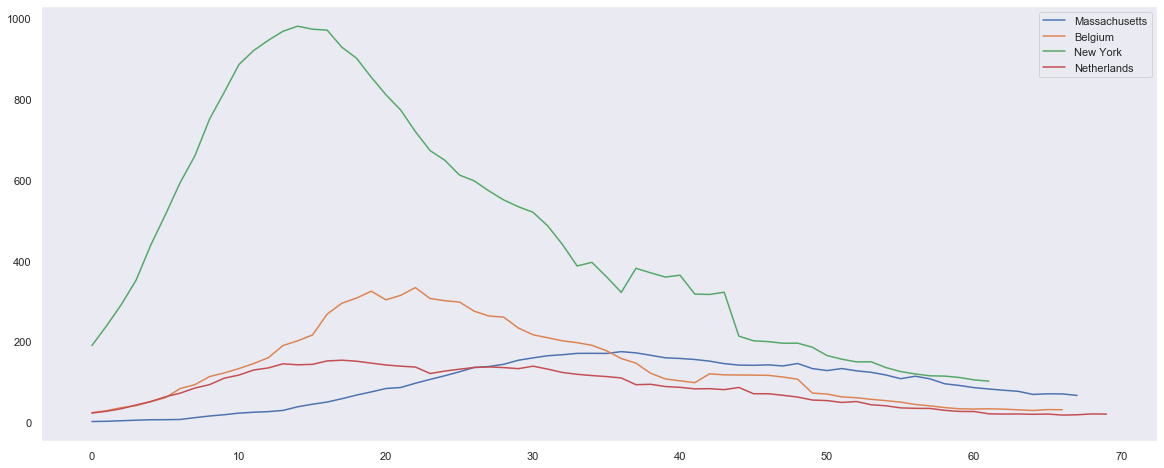

In [61]:
targets = ['Massachusetts', 'Belgium', 'New York', 'Netherlands']
deaths_intervention_adjusted_daily[targets].plot(), plt.grid()

In [62]:
deaths_peak = list(global_peak_size.index)
cases_peak = list(global_peak_size_cases.index)
common_places = set(deaths_peak).intersection(cases_peak)
common_places2 = list(set(global_peak_size.index) & set(global_peak_size_cases.index))

In [63]:
global_peak_size['lags'] = global_peak_size.loc[common_places2, "days to peak"]-global_peak_size_cases.loc[common_places2, "days to peak"]

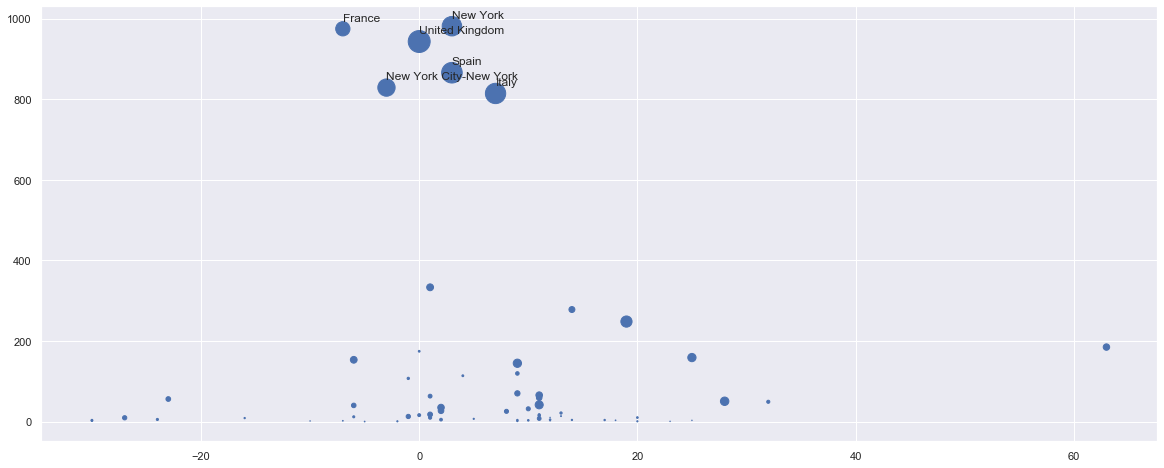

In [64]:
plt.scatter(global_peak_size['lags'], (global_peak_size['peak value']), s=2*global_peak_size['initial value']),
variablelabel = global_peak_size.index

for i, txt in enumerate(variablelabel):
    if(global_peak_size['peak value'][i]>500):
        plt.annotate(txt, (global_peak_size['lags'][i], global_peak_size['peak value'][i]+20))

        variablelabel = global_peak_size.index


<Figure size 1152x864 with 0 Axes>

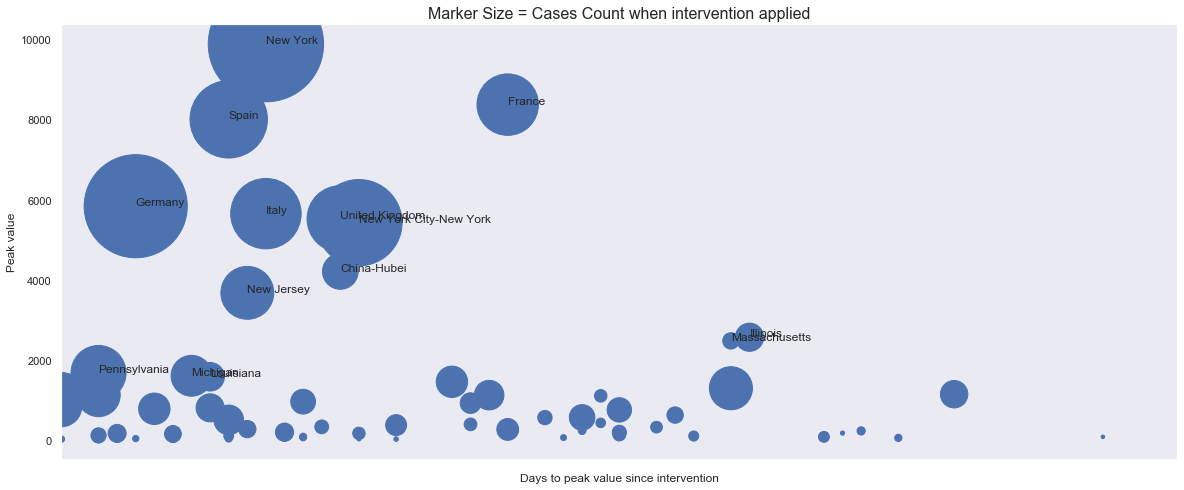

In [65]:
plt.figure(figsize=(16,12))
fig, ax = plt.subplots(1,1)


tick_spacing = 30
# this is a bug in matplotlib
plt.rcParams['figure.figsize'] = (16.0, 12.0)

label_markings = ax.get_xticklabels()
ax.set_xticklabels(label_markings, rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.xlim([0,60])
plt.scatter(global_peak_size_cases['days to peak'], (global_peak_size_cases['peak value']), s=2*global_peak_size_cases['initial value']),
#plt.scatter(global_peak_size_thresh['days to peak'], (global_peak_size_thresh['peak value']), s=2*global_peak_size_thresh['initial value'], color='r'), 
plt.xlabel('Days to peak value since intervention'), plt.title('Marker Size = Cases Count when intervention applied', fontdict = {'fontsize' : 16}), plt.ylabel('Peak value'), plt.grid()
variablelabel = global_peak_size_cases.index

for i, txt in enumerate(variablelabel):
    if(global_peak_size_cases['peak value'][i]>1500):
        plt.annotate(txt, (global_peak_size_cases['days to peak'][i], global_peak_size_cases['peak value'][i]+20))

        variablelabel = global_peak_size.index

(array([14., 16., 12.,  5.,  5., 10.,  5.,  3.,  2.,  1.]),
 array([ 0. ,  5.6, 11.2, 16.8, 22.4, 28. , 33.6, 39.2, 44.8, 50.4, 56. ]),
 <a list of 10 Patch objects>)

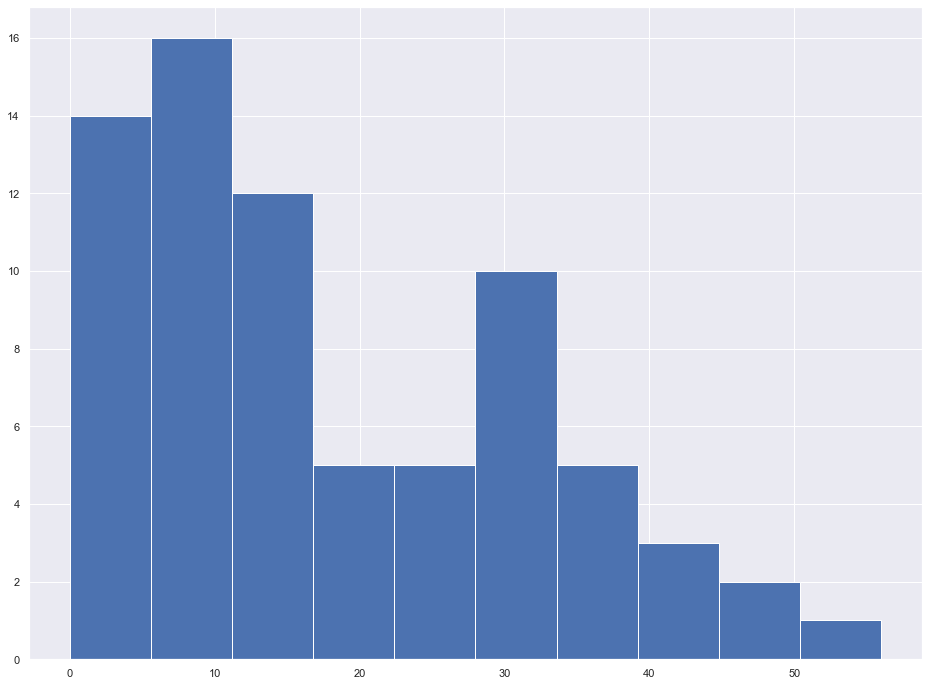

In [66]:
plt.hist(global_peak_size_cases['days to peak'])

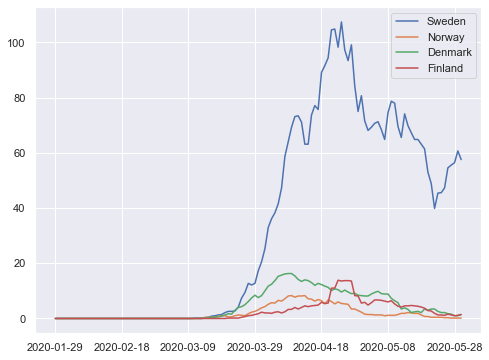

In [67]:
plt.rcParams['figure.figsize'] = (8.0, 6.0)

all_data_daily[['Sweden', 'Norway', 'Denmark', 'Finland']].plot()

In [68]:
# load and clean mobility data

mobility_data_apple = pd.read_csv("../data/applemobilitytrends-2020-05-30.csv")
mobility_data_google = pd.read_csv("../data/Global_Mobility_Report.csv", low_memory=False)

mobility_global = mobility_data_google.pivot_table(index='date', values='retail_and_recreation_percent_change_from_baseline', columns='country_region')

google_work_country = mobility_data_google.pivot_table(index='date', columns='country_region', values='workplaces_percent_change_from_baseline')
global_google = google_work_country[google_work_country.lt(-30)].apply(pd.Series.first_valid_index)
google_work_us = mobility_data_google[mobility_data_google.country_region ==  "United States"].pivot_table(index='date', values=mobility_data_google.columns[9], columns='sub_region_1')
us_google = google_work_us[google_work_us.lt(-30)].apply(pd.Series.first_valid_index)
google_social = pd.DataFrame(data=pd.concat([global_google, us_google]), columns=['date'])
google_social['date'] = pd.to_datetime(google_social['date'])
google_social['name'] = google_social.index



16


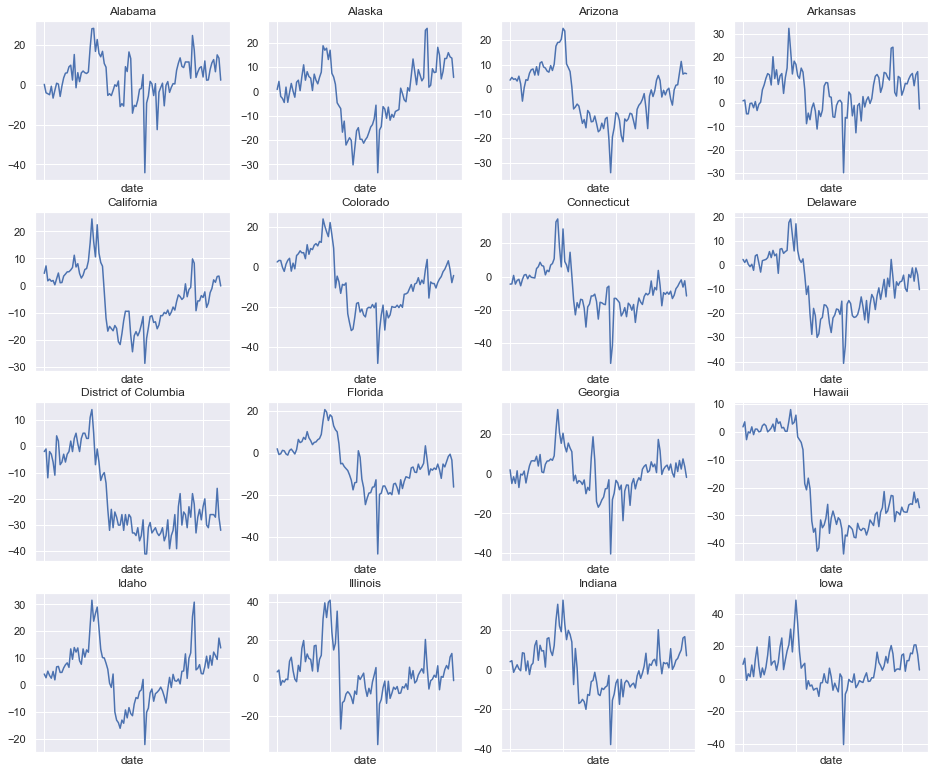

32


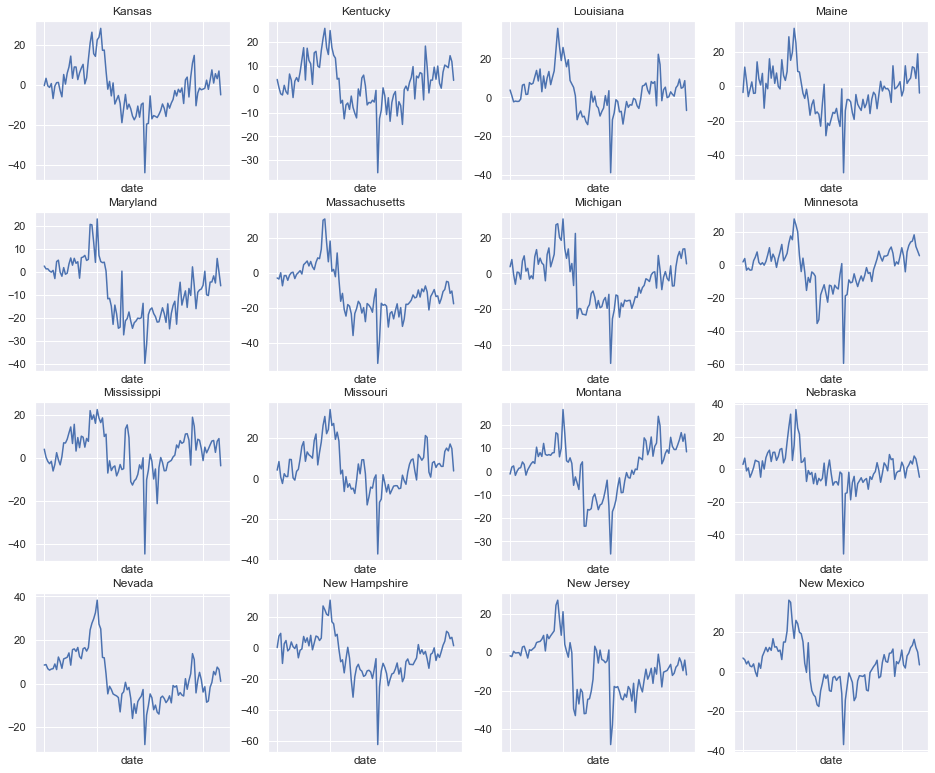

48


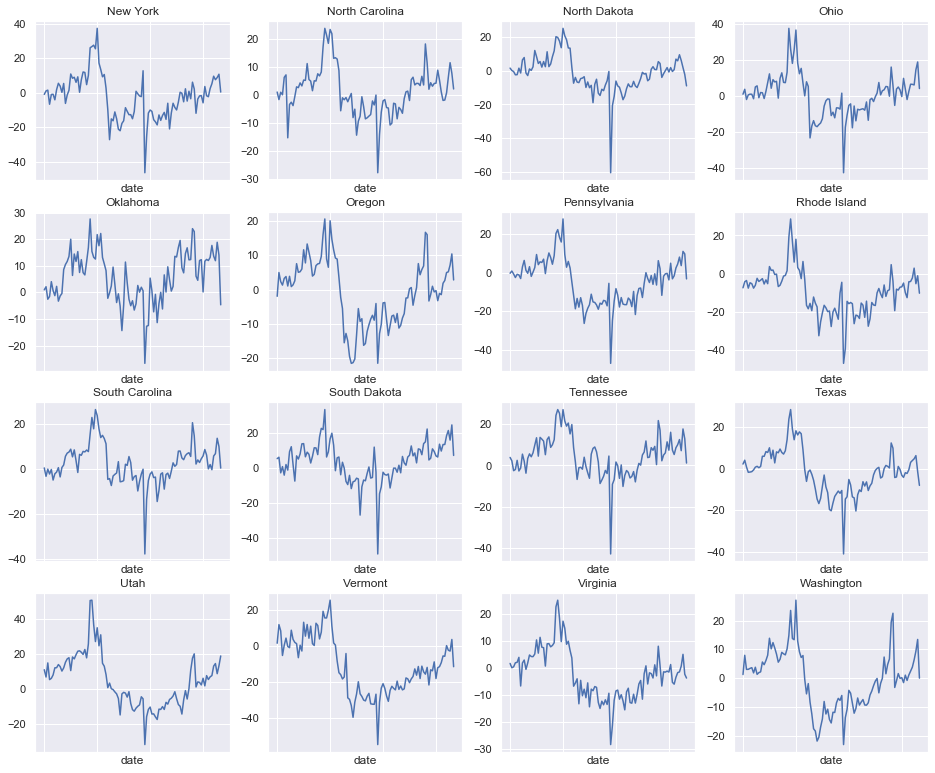

[('Alabama', datetime.datetime(2020, 4, 26, 0, 0)), ('Alaska', datetime.datetime(2020, 4, 24, 0, 0)), ('Arizona', datetime.datetime(2020, 5, 6, 0, 0)), ('Arkansas', datetime.datetime(2020, 4, 22, 0, 0)), ('California', datetime.datetime(2020, 4, 29, 0, 0)), ('Colorado', datetime.datetime(2020, 5, 18, 0, 0)), ('Connecticut', datetime.datetime(2020, 5, 21, 0, 0)), ('Delaware', datetime.datetime(2020, 5, 21, 0, 0)), ('District of Columbia', datetime.datetime(2020, 2, 24, 0, 0)), ('Florida', datetime.datetime(2020, 5, 21, 0, 0)), ('Georgia', datetime.datetime(2020, 4, 26, 0, 0)), ('Hawaii', datetime.datetime(2020, 2, 17, 0, 0)), ('Idaho', datetime.datetime(2020, 4, 16, 0, 0)), ('Illinois', datetime.datetime(2020, 4, 22, 0, 0)), ('Indiana', datetime.datetime(2020, 4, 22, 0, 0)), ('Iowa', datetime.datetime(2020, 4, 15, 0, 0)), ('Kansas', datetime.datetime(2020, 5, 14, 0, 0)), ('Kentucky', datetime.datetime(2020, 4, 29, 0, 0)), ('Louisiana', datetime.datetime(2020, 4, 22, 0, 0)), ('Maine', da

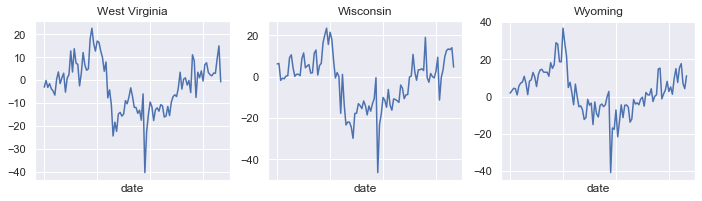

In [69]:
#state_list = ['Massachusetts', 'New Jersey', 'New York', 'California', 'Washington']
state_list = newdf.columns
plt.rcParams['figure.figsize'] = (16.0, 45.0)

newfig=[16,32,48]

tick_spacing = 30
#print((state_list))

mobility_us = mobility_data_google.loc[mobility_data_google.country_region == 
                                       "United States"].pivot_table(index='date', values=mobility_data_google.columns[6], columns='sub_region_1')
states_reopenings = []
for i in range(1,52):
    ax = plt.subplot(13,4, i)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plt.setp( ax.get_xticklabels(), visible=False)

    #plt.setp( ax.get_xticklabels(), visible=False)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


    mobility_us[state_list[i-1]].plot(ax=ax, title = state_list[i-1])
    count = 0 
    max_days = 3
    min_mobility = -10
    end_date = -1
    for (date, value) in list(zip(mobility_us[state_list[i-1]].index,mobility_us[state_list[i-1]])):
        if value < min_mobility:
            count = 0
        elif value >= min_mobility:
            count += 1
        if count == max_days:
            end_date = date
    
    states_reopenings.append((state_list[i-1], datetime.datetime.strptime(end_date,'%Y-%m-%d')))
    #print(end_date, mobility_us[state_list[i-1]].index[0], mobility_us[state_list[i-1]].index[-1])
    
    if i in newfig:
        print(i)
        plt.show()

print(states_reopenings)


In [154]:
def create_filtered_data_and_date(df, threshold):
    pattern = re.compile('(Unknown|Unassigned)')
    newdf = pd.DataFrame()
    threshold_dates = {}
    for location in df.columns:
        if(pattern.search(location)):
            continue
        highnumber = df[df[location].gt(threshold)]
        if(len(highnumber)>0):
            threshold_dates[location] = datetime.datetime.strptime(df.loc[highnumber.index[0]:,location].index[0],'%Y-%m-%d')
            newdf = pd.concat([newdf, pd.DataFrame(columns=[location], data=df.loc[highnumber.index[0]:,location].values)], axis=1)
            
    return newdf,threshold_dates

def find_lockdown_date(df, mobility_us, max_days = 1, min_mobility = -10):
    pattern = re.compile('(Unknown|Unassigned)')
    newdf = pd.DataFrame()
    lockdown_dates = {}
    for i in range(1,52):
        count = 0 
        for (date, value) in list(zip(mobility_us[state_list[i-1]].index,mobility_us[state_list[i-1]])):
            if value <= min_mobility:
                count += 1
            elif value >= min_mobility:
                count = 0
            if count == max_days:
                location = state_list[i-1]
                if(pattern.search(location)):
                    continue
                start_date = datetime.datetime.strptime(date,'%Y-%m-%d')
                
                tmp = pd.DataFrame(pd.to_datetime(df[location].index))
                highnumber = df[tmp.gt(start_date)]
                #highnumber2 = df[df[location].gt(0)]
                
                if(len(highnumber)>0):
                    newdf = pd.concat([newdf, pd.DataFrame(columns=[location], data=df.loc[highnumber.index[0]:,location].values)], axis=1)
                    lockdown_dates[location] = start_date
                break

        #print(end_date, mobility_us[state_list[i-1]].index[0], mobility_us[state_list[i-1]].index[-1])
    return newdf, lockdown_dates


daily_us = create_filtered_data(uscases,1)
daily_us, lockdown_dates = find_lockdown_date(uscases, mobility_us)
#print(daily_us)





In [124]:
print(daily_us)

print(daily_us2)

     Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  \
0        6.0     3.0      2.0       6.0         2.0       2.0          2.0   
1       12.0     6.0      2.0       7.0         2.0       8.0          2.0   
2       23.0     9.0      2.0       9.0         2.0       8.0          3.0   
3       29.0    12.0      3.0      16.0         2.0       8.0          6.0   
4       39.0    14.0      5.0      22.0         2.0      12.0         11.0   
..       ...     ...      ...       ...         ...       ...          ...   
121      NaN     NaN      NaN       NaN     99925.0       NaN          NaN   
122      NaN     NaN      NaN       NaN    101874.0       NaN          NaN   
123      NaN     NaN      NaN       NaN    104071.0       NaN          NaN   
124      NaN     NaN      NaN       NaN    107043.0       NaN          NaN   
125      NaN     NaN      NaN       NaN    110100.0       NaN          NaN   

     Delaware  District of Columbia  Florida  ...  Tennessee  T

In [152]:


highnumber1 = uscases['Alabama'].gt(0)
print((highnumber1))
#print(df[highnumber])

#df.loc[df[highnumber].index[0]:,location].values
start_date = datetime.datetime.strptime('2020-05-26','%Y-%m-%d')
#tmp = df[df['Alabama'].index]
tmp = pd.DataFrame(pd.to_datetime(uscases['Alabama'].index))
#tmp = pd.to_datetime(df['col'])
highnumber2 = tmp.gt(start_date)
print((highnumber2))
highnumber = highnumber1[0] & highnumber2['date']
print(highnumber1)

date
2020-01-21    False
2020-01-22    False
2020-01-23    False
2020-01-24    False
2020-01-25    False
              ...  
2020-05-26     True
2020-05-27     True
2020-05-28     True
2020-05-29     True
2020-05-30     True
Name: Alabama, Length: 131, dtype: bool
      date
0    False
1    False
2    False
3    False
4    False
..     ...
126  False
127   True
128   True
129   True
130   True

[131 rows x 1 columns]
date
2020-01-21    False
2020-01-22    False
2020-01-23    False
2020-01-24    False
2020-01-25    False
              ...  
2020-05-26     True
2020-05-27     True
2020-05-28     True
2020-05-29     True
2020-05-30     True
Name: Alabama, Length: 131, dtype: bool


In [145]:
print(df)

      Austria    Belgium  Bulgaria  China-Hubei   Croatia    Cyprus   Czechia  \
0    2.571429  23.428571  0.142857    20.714286  0.285714  0.714286  0.142857   
1    3.571429  28.428571  0.142857    25.714286  0.285714  0.857143  0.428571   
2    3.714286  36.000000  0.000000    29.857143  0.571429  1.000000  0.857143   
3    6.142857  40.857143  0.000000    42.571429  0.714286  0.857143  1.285714   
4    7.428571  50.857143  0.571429    48.285714  0.714286  0.857143  1.285714   
..        ...        ...       ...          ...       ...       ...       ...   
117       NaN        NaN       NaN     0.000000       NaN       NaN       NaN   
118       NaN        NaN       NaN     0.000000       NaN       NaN       NaN   
119       NaN        NaN       NaN     0.000000       NaN       NaN       NaN   
120       NaN        NaN       NaN     0.000000       NaN       NaN       NaN   
121       NaN        NaN       NaN     0.000000       NaN       NaN       NaN   

      Denmark   Estonia   F

In [157]:
# find day since 10 deaths for each state
# count how many days after that reopening happens
# use states with higher number of days to predict the ones with lower and vice versa

reopening_delta = {}
for (state, date) in states_reopenings:
    try:
        reopening_delta[state] = (date - lockdown_dates[state]).days
    except:
        continue
        
print(reopening_delta) 


opened_states = []
closed_states = []
max_days = 60
min_days = 50


for state in reopening_delta:
    if reopening_delta[state] >= max_days or reopening_delta[state] < 0 :
        # less than zero for the ones which have not yet opened. 
        closed_states.append(state)
    elif reopening_delta[state] > min_days:
        opened_states.append(state)
    




{'Alabama': 28, 'Alaska': 32, 'Arizona': 41, 'Arkansas': 25, 'California': 39, 'Colorado': 60, 'Connecticut': 60, 'Delaware': 60, 'District of Columbia': 7, 'Florida': 55, 'Georgia': 28, 'Hawaii': -33, 'Idaho': 20, 'Illinois': 31, 'Indiana': 28, 'Iowa': 17, 'Kansas': 45, 'Kentucky': 36, 'Louisiana': 29, 'Maine': 67, 'Maryland': 60, 'Massachusetts': 61, 'Michigan': 39, 'Minnesota': 32, 'Mississippi': 18, 'Missouri': 11, 'Montana': 21, 'Nebraska': 27, 'Nevada': 25, 'New Hampshire': 86, 'New Jersey': 60, 'New Mexico': 27, 'New York': 52, 'North Carolina': 62, 'North Dakota': 24, 'Ohio': 36, 'Oklahoma': 23, 'Oregon': 35, 'Pennsylvania': 53, 'Rhode Island': 60, 'South Carolina': 10, 'South Dakota': 25, 'Tennessee': 10, 'Texas': 32, 'Utah': 38, 'Vermont': 60, 'Virginia': 39, 'Washington': 28, 'West Virginia': 36, 'Wisconsin': 59, 'Wyoming': 30}


     Colorado  Connecticut  Delaware  Hawaii   Maine  Maryland  Massachusetts  \
0         NaN          NaN       NaN     NaN     NaN       NaN            NaN   
1         NaN          NaN       NaN     NaN     NaN       NaN            NaN   
2         NaN          NaN       NaN     NaN     NaN       NaN            NaN   
3         NaN          NaN       NaN     NaN     NaN       NaN            NaN   
4         NaN          NaN       NaN     NaN     NaN       NaN            NaN   
..        ...          ...       ...     ...     ...       ...            ...   
126   24553.0      41303.0    9066.0   633.0  2109.0   48290.0        93693.0   
127   24775.0      41288.0    9096.0   634.0  2137.0   49042.0        94220.0   
128   25116.0      41559.0    9171.0   637.0  2189.0   50334.0        94895.0   
129   25602.0      41762.0    9236.0   639.0  2226.0   51631.0        95512.0   
130   26084.0      42022.0    9422.0   641.0  2282.0   52662.0        96301.0   

     New Hampshire  New Jer

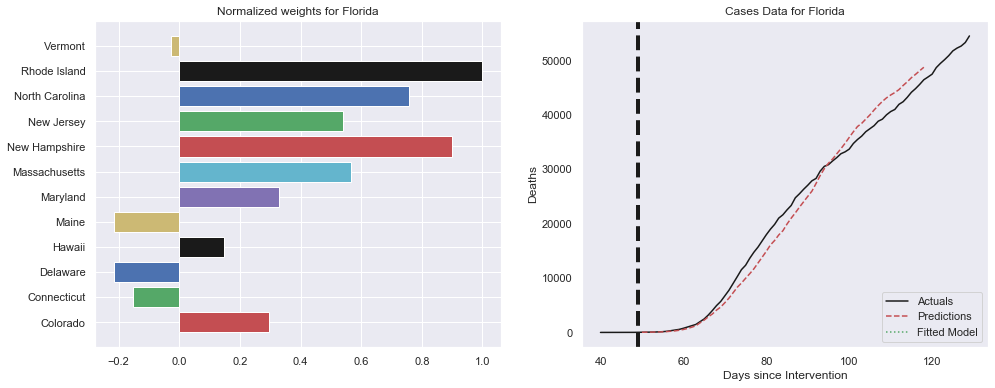

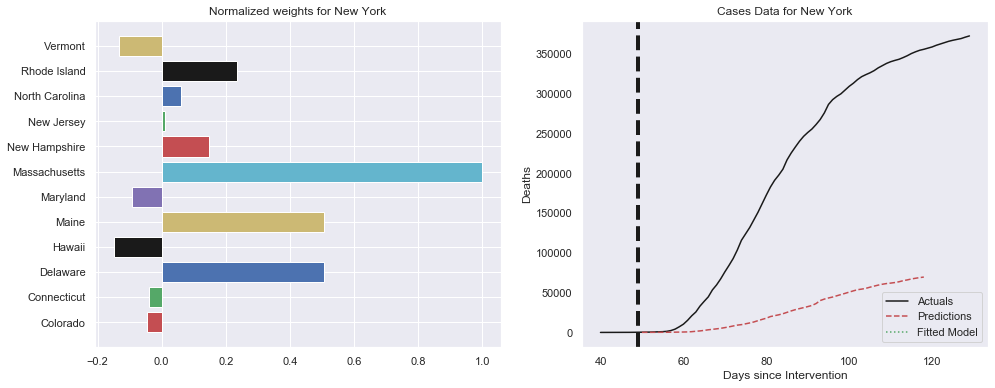

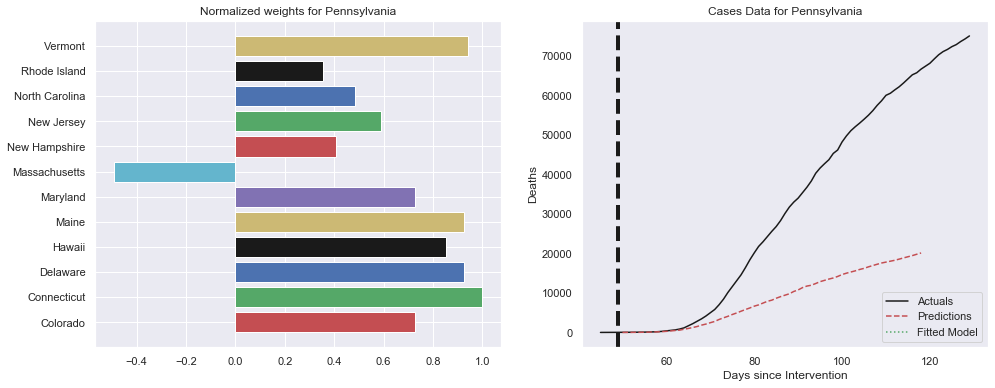

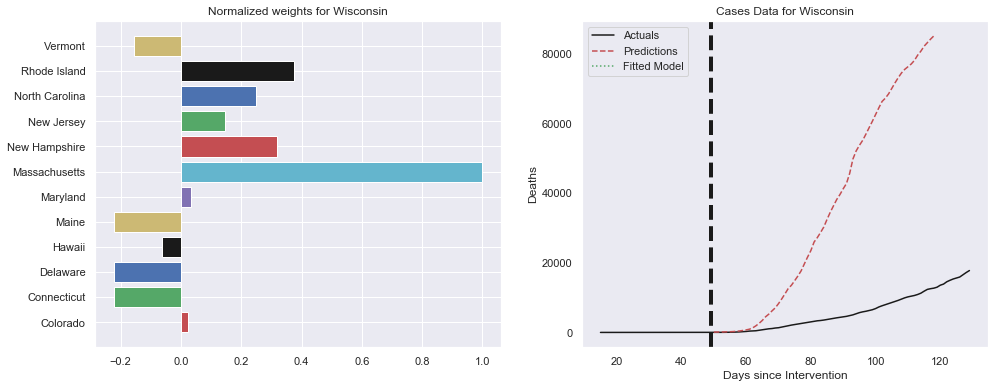

In [159]:
'''
return_value = synth_control_predictions([pd.concat([deaths_intervention_adjusted_daily,temp_df], axis=1)], 42,22, "5-day moving average of daily deaths", singVals, ylimit=[], 
                                   savePlots=False, do_only=[target+" -%s"%i], showstates=12,
                                   exclude=[target], animation=camera, showDonors=False, silent=False, showPlots=True)
    
'''
for target in opened_states:
    trial =  pd.concat([daily_us[closed_states], daily_us[[target]]], axis=1)# daily_us[closed_states]# pd.concat([daily_us[closed_states], daily_us[opened_states]], axis=1)
    print(trial)
    return_value = synth_control_predictions([trial], 120,min_days, "Cases Data", singVals, ylimit=[], 
                               savePlots=False, do_only=[target], showstates=12,
                               exclude=[target], animation=camera, showDonors=True, silent=False, showPlots=True)

    #synth_control_predictions2(trial,max_days,min_days, "Cases Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
    #                           exclude=matching+matching_us, svdSpectrum=False)
    #except: 
    #    continue